In [1]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

# Data Splitting and Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# Evaluation Metrics
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score


# Saving Model
from joblib import dump
import pickle

# Others
#import shap
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE


# Set seaborn defaults and suppress warnings
sns.set()
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Paitients_Files_Train.csv")
df_ts = pd.read_csv("Paitients_Files_Test.csv")
df_tr = df.copy()




# Dataset Overview

### About this Data
- ID: number to represent patient ID
- PRG: Plasma glucose
- PL: Blood Work Result-1 (mu U/ml)
- PR: Blood Pressure (mm Hg)
- SK: Blood Work Result-2 (mm)
- TS: Blood Work Result-3 (mu U/ml)
- M11: Body mass index (weight in kg)/(height in m)^2
- BD2: Blood Work Result-4 (mu U/ml)
- Age: patients age (years)
- Insurance: If a patient holds a valid insurance card
- Sepsis:  Positive: if a patient in ICU will develop a sepsis , and
      Negative: otherwise

In [3]:
#First Five Rows of the train dataset
df_tr.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive

In [4]:
#First Five Rows of the test dataset
df_ts.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance
0  ICU200609    1  109  38  18  120  23.1  0.407   26          1
1  ICU200610    1  108  88  19    0  27.1  0.400   24          1
2  ICU200611    6   96   0   0    0  23.7  0.190   28          1
3  ICU200612    1  124  74  36    0  27.8  0.100   30          1
4  ICU200613    7  150  78  29  126  35.2  0.692   54          0

In [5]:
#basic information about columns in Train Dataset
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [6]:
#basic information about columns in Test Dataset
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


In [7]:
#Check dimension of train dataset
print(df_tr.shape)
print("Number of rows for Train data:", df_tr.shape[0])
print("Number of columns for Train data:", df_tr.shape[1])

(599, 11)
Number of rows for Train data: 599
Number of columns for Train data: 11


In [8]:
#Check dimension of test dataset
print(df_ts.shape)
print("Number of rows for Test Data:", df_ts.shape[0])
print("Number of columns for Test Data:", df_ts.shape[1])

(169, 10)
Number of rows for Test Data: 169
Number of columns for Test Data: 10


In [9]:
#Explore the summary statistics of numerical columns:
df_tr.describe().T

count        mean         std     min     25%      50%      75%  \
PRG        599.0    3.824708    3.362839   0.000   1.000    3.000    6.000   
PL         599.0  120.153589   32.682364   0.000  99.000  116.000  140.000   
PR         599.0   68.732888   19.335675   0.000  64.000   70.000   80.000   
SK         599.0   20.562604   16.017622   0.000   0.000   23.000   32.000   
TS         599.0   79.460768  116.576176   0.000   0.000   36.000  123.500   
M11        599.0   31.920033    8.008227   0.000  27.100   32.000   36.550   
BD2        599.0    0.481187    0.337552   0.078   0.248    0.383    0.647   
Age        599.0   33.290484   11.828446  21.000  24.000   29.000   40.000   
Insurance  599.0    0.686144    0.464447   0.000   0.000    1.000    1.000   

              max  
PRG         17.00  
PL         198.00  
PR         122.00  
SK          99.00  
TS         846.00  
M11         67.10  
BD2          2.42  
Age         81.00  
Insurance    1.00

##### **PRG**

- Count: 599
- Mean: 3.82
- Standard Deviation: 3.36
- Range: 0 to 17

##### **PL**

- Count: 599
- Mean: 120.15
- Standard Deviation: 32.68
- Range: 0 to 198

##### **PR**

- Count: 599
- Mean: 68.73
- Standard Deviation: 19.34
- Range: 0 to 122

##### **SK**

- Count: 599
- Mean: 20.56
- Standard Deviation: 16.02
- Range: 0 to 99

##### **TS**

- Count: 599
- Mean: 79.46
- Standard Deviation: 116.58
- Range: 0 to 846

##### **M11**

- Count: 599
- Mean: 31.92
- Standard Deviation: 8.01
- Range: 0 to 67.1

##### **BD2**

- Count: 599
- Mean: 0.48
- Standard Deviation: 0.34
- Range: 0.078 to 2.42

##### **Age**

- Count: 599
- Mean: 33.29
- Standard Deviation: 11.83
- Range: 21 to 81

##### **Insurance**

- Count: 599
- Mean: 0.686
- Standard Deviation: 0.464
- Range: 0 to 1
- Proportion with Insurance: 0.686 (68.6%)


In [10]:
#Explore the summary statistics of numerical columns:
df_ts.describe().T

count        mean         std   min      25%      50%      75%  \
PRG        169.0    3.917160    3.402415   0.0    1.000    3.000    6.000   
PL         169.0  123.520710   29.259123  56.0  102.000  120.000  141.000   
PR         169.0   70.426036   19.426805   0.0   62.000   74.000   80.000   
SK         169.0   20.443787   15.764962   0.0    0.000   23.000   32.000   
TS         169.0   81.000000  110.720852   0.0    0.000    0.000  135.000   
M11        169.0   32.249704    7.444886   0.0   27.600   32.400   36.600   
BD2        169.0    0.438876    0.306935   0.1    0.223    0.343    0.587   
Age        169.0   33.065089   11.548110  21.0   24.000   28.000   42.000   
Insurance  169.0    0.727811    0.446410   0.0    0.000    1.000    1.000   

               max  
PRG         13.000  
PL         199.000  
PR         114.000  
SK          49.000  
TS         540.000  
M11         57.300  
BD2          1.698  
Age         70.000  
Insurance    1.000

##### **PRG**

- Count: 169
- Mean: 3.9171
- Standard Deviation: 3.4024
- Range: 0 to 13

##### **PL**

- Count: 169
- Mean: 123.5207
- Standard Deviation: 29.2591
- Range: 56 to 199

##### **PR**

- Count: 169
- Mean: 70.4260
- Standard Deviation: 19.4268
- Range: 0 to 114

##### **SK**

- Count: 169
- Mean: 20.4437
- Standard Deviation: 15.7649
- Range: 0 to 49

##### **TS**

- Count: 169
- Mean: 81.00
- Standard Deviation: 110.7208
- Range: 0 to 540

##### **M11**

- Count: 169
- Mean: 32.2497
- Standard Deviation: 7.4448
- Range: 0 to 57.3

##### **BD2**

- Count: 169
- Mean: 0.4388
- Standard Deviation: 0.3069
- Range: 0.1 to 1.698

##### **Age**

- Count: 169
- Mean: 33.065
- Standard Deviation: 11.5481
- Range: 21 to 70

##### **Insurance**

- Count: 169
- Mean: 0.7278
- Standard Deviation: 0.446
- Range: 0 to 1
- Proportion with Insurance: 0.7278 (72.78%)


In [11]:
# create a function to print the number of unique values
def print_unique_values(data):
    values = {}
    for col in data.columns:
        number = data[col].nunique()
        print(f'{col}: has {number} of unique values') 

In [12]:
print_unique_values(df_tr)

ID: has 599 of unique values
PRG: has 17 of unique values
PL: has 129 of unique values
PR: has 44 of unique values
SK: has 51 of unique values
TS: has 164 of unique values
M11: has 233 of unique values
BD2: has 437 of unique values
Age: has 50 of unique values
Insurance: has 2 of unique values
Sepssis: has 2 of unique values


In [13]:
print_unique_values(df_ts)

ID: has 169 of unique values
PRG: has 14 of unique values
PL: has 85 of unique values
PR: has 33 of unique values
SK: has 36 of unique values
TS: has 66 of unique values
M11: has 122 of unique values
BD2: has 156 of unique values
Age: has 39 of unique values
Insurance: has 2 of unique values


## Univariate Analysis 

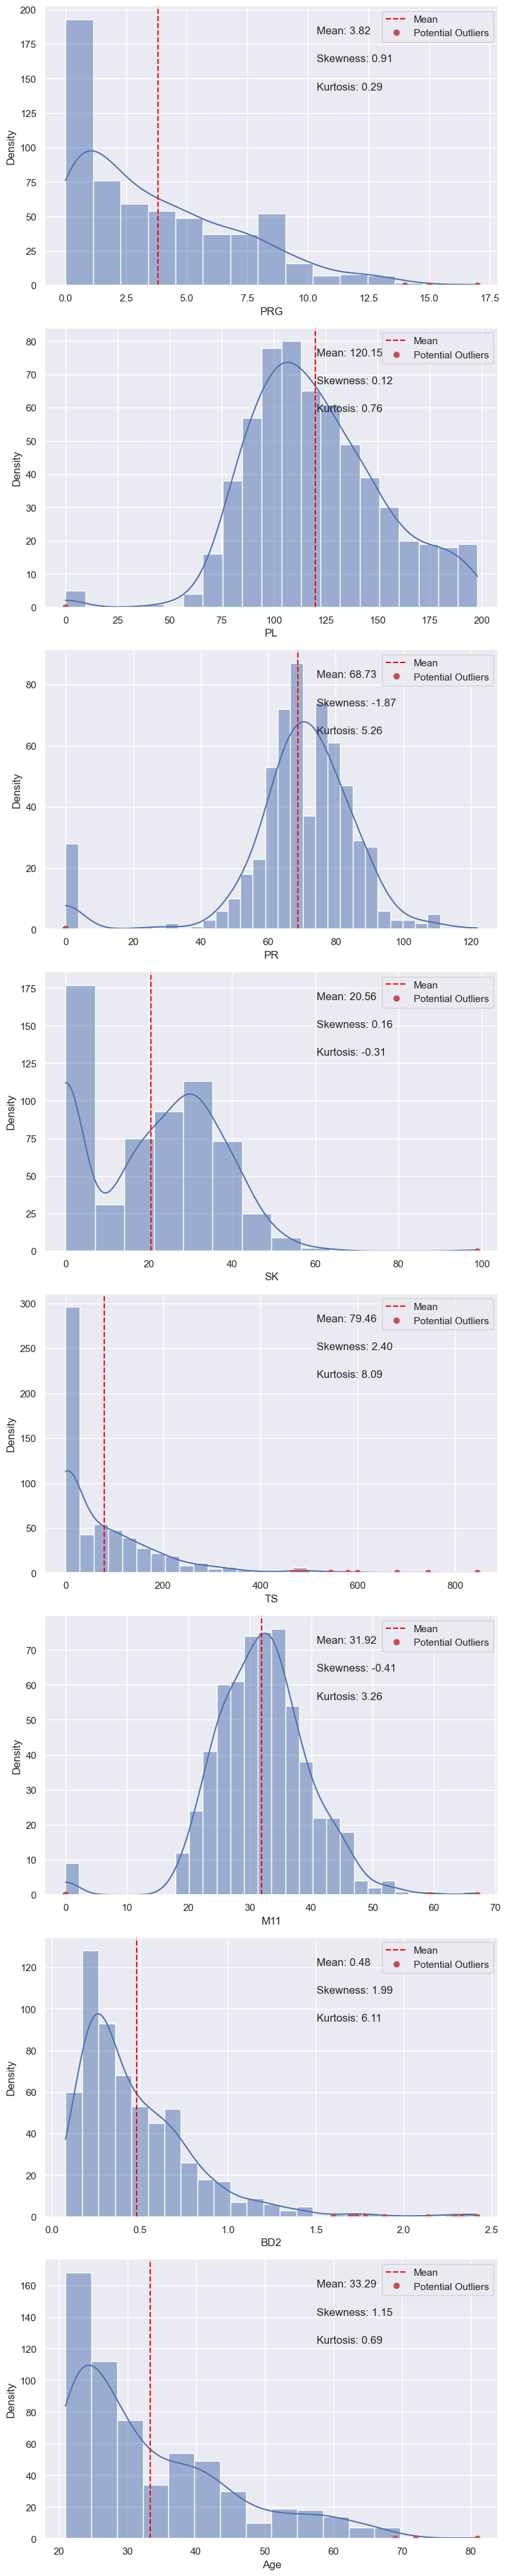

In [14]:
cols_to_plot = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

fig, axes = plt.subplots(nrows=len(cols_to_plot), figsize=(8, 40))

for i, col in enumerate(cols_to_plot):
    sns.histplot(data=df_tr, x=col, kde=True, ax=axes[i], fill=True)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    
    mean_val = df_tr[col].mean()
    skewness_val = df_tr[col].skew()
    kurtosis_val = df_tr[col].kurtosis()
    
    axes[i].text(0.6, 0.9, f'Mean: {mean_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.8, f'Skewness: {skewness_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.7, f'Kurtosis: {kurtosis_val:.2f}', transform=axes[i].transAxes)
    
    axes[i].axvline(mean_val, color='red', linestyle='--', label='Mean')
    
    outliers = df_tr[(df_tr[col] > mean_val + 3 * df_tr[col].std()) | (df_tr[col] < mean_val - 3 * df_tr[col].std())]
    axes[i].plot(outliers[col], [0] * len(outliers), 'ro', label='Potential Outliers')
    
    axes[i].legend()

plt.tight_layout()
plt.show()


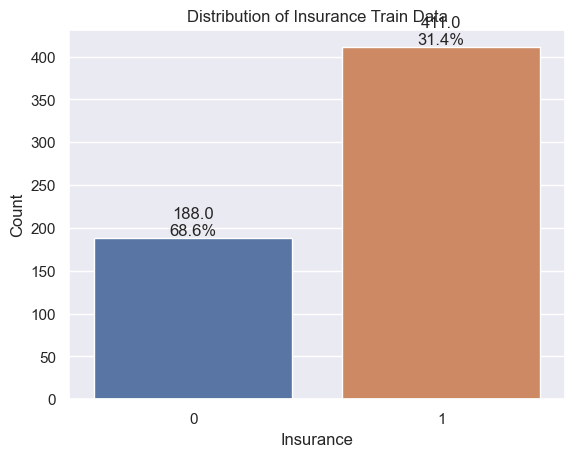

In [15]:
# Count plot for "Insurance" 
sns.countplot(data=df_tr, x='Insurance')

# Set labels
plt.xlabel('Insurance')
plt.ylabel('Count')

# Set title
plt.title('Distribution of Insurance Train Data')

# Calculate percentage distribution
total = len(df_tr['Insurance'])
percentages = df_tr['Insurance'].value_counts(normalize=True) * 100

# Add data labels and percentage annotations
for p, percentage in zip(plt.gca().patches, percentages):
    count = p.get_height()
    percentage_label = f'{percentage:.1f}%'
    plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.show()

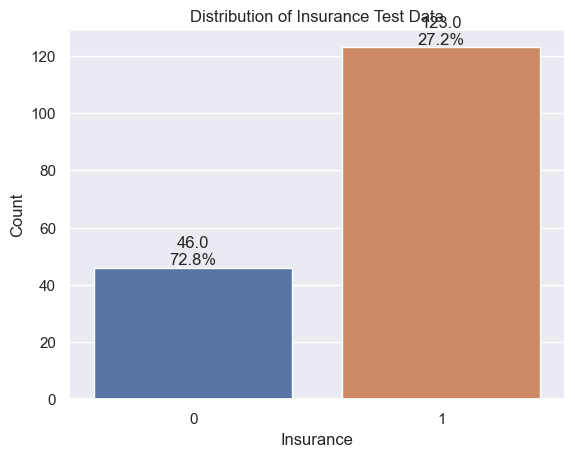

In [16]:
# Count plot for "Insurance" 
sns.countplot(data=df_ts, x='Insurance')

# Set labels
plt.xlabel('Insurance')
plt.ylabel('Count')

# Set title
plt.title('Distribution of Insurance Test Data')

# Calculate percentage distribution
total = len(df_ts['Insurance'])
percentages = df_ts['Insurance'].value_counts(normalize=True) * 100

# Add data labels and percentage annotations
for p, percentage in zip(plt.gca().patches, percentages):
    count = p.get_height()
    percentage_label = f'{percentage:.1f}%'
    plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.show()

In [17]:
# Encoding the target variable
df_tr['Sepssis_Encoded'] = df_tr['Sepssis'].map({'Negative': 0, 'Positive': 1})

# Dropping unneeded column
df_tr.drop('ID', axis=1, inplace=True)
df_ts.drop('ID', axis=1, inplace=True)

## BIVARIATE ANALYSIS

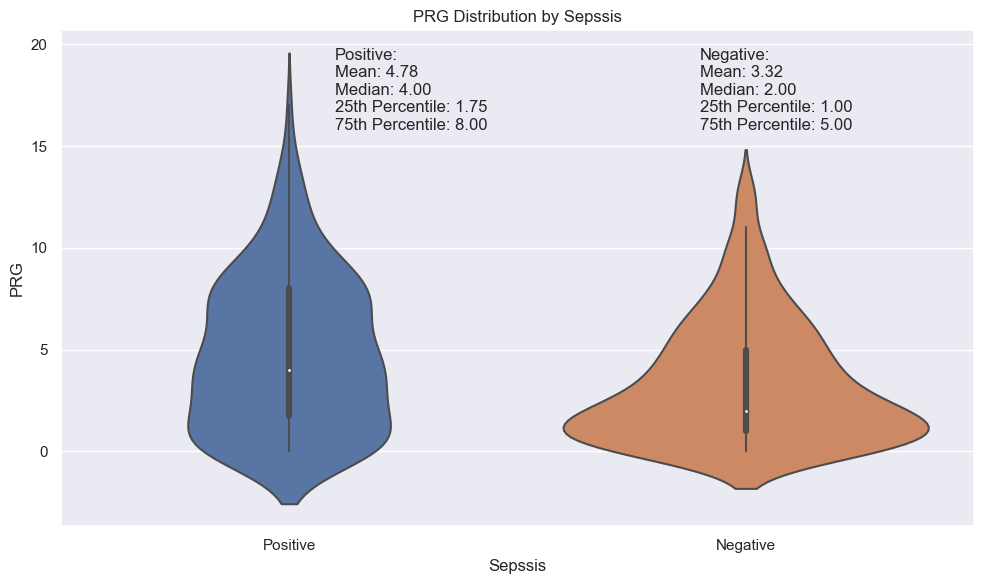

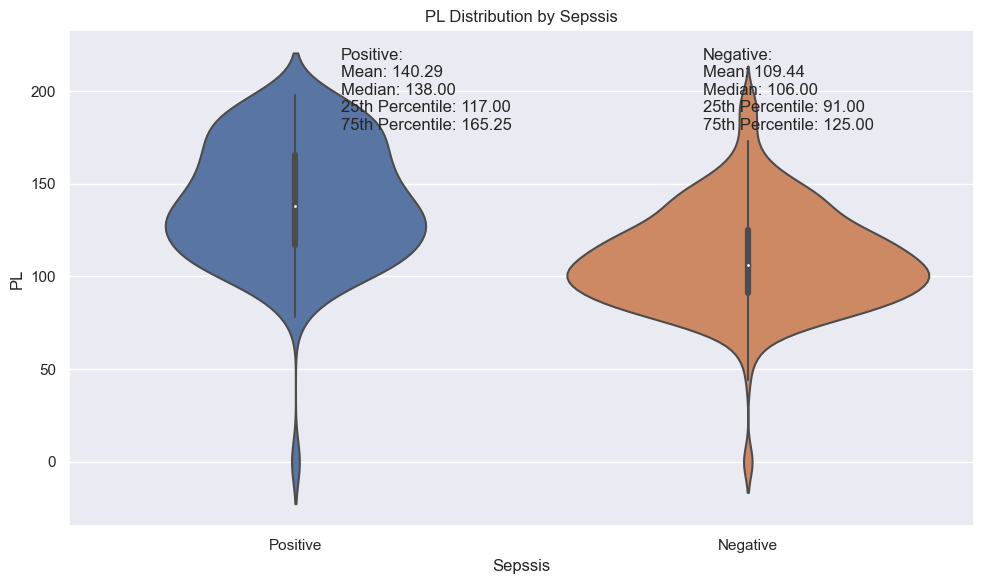

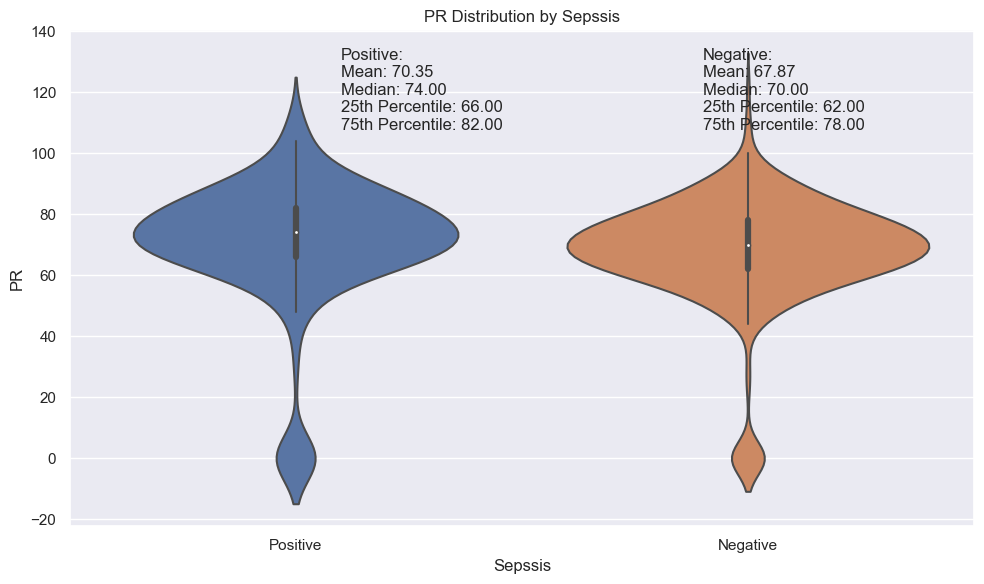

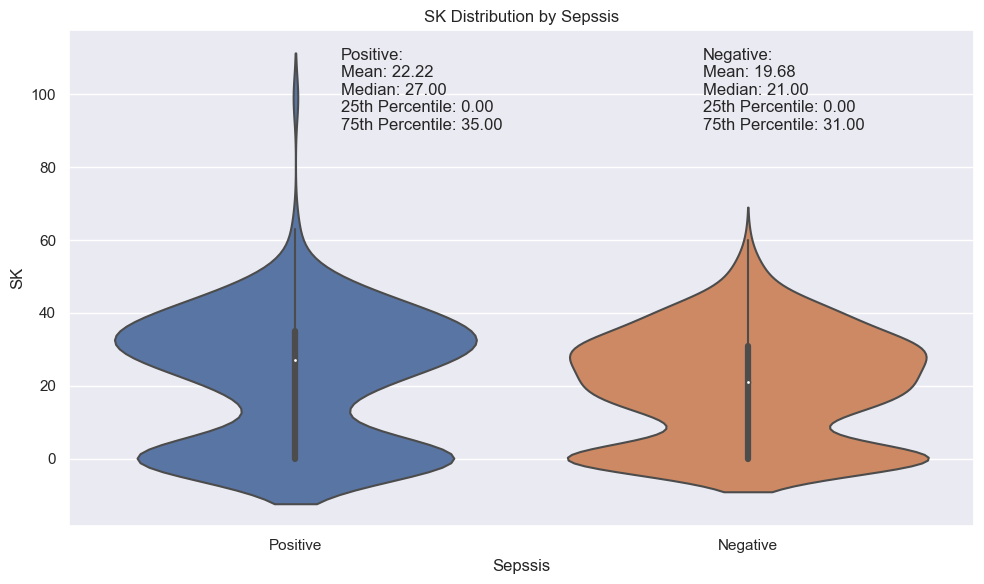

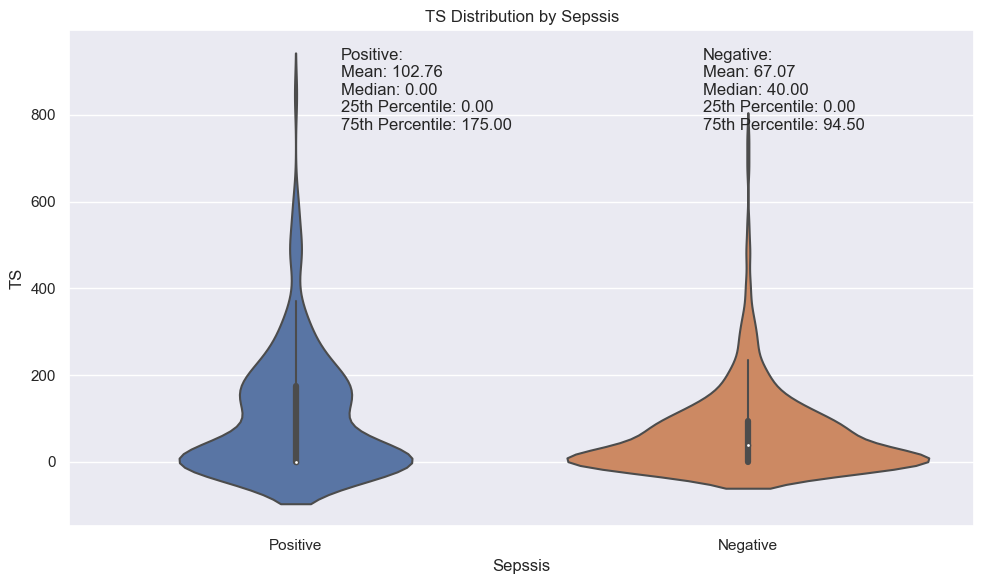

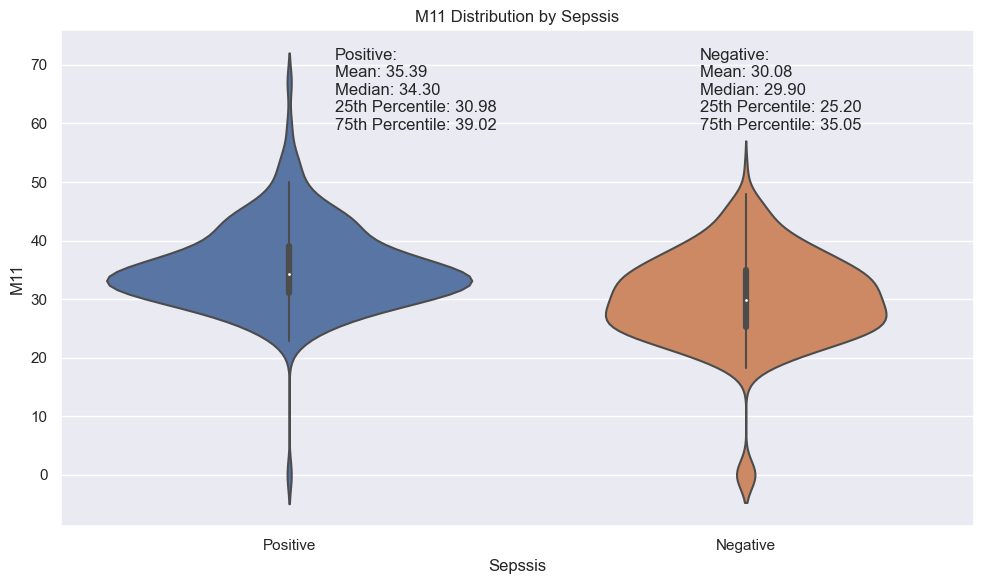

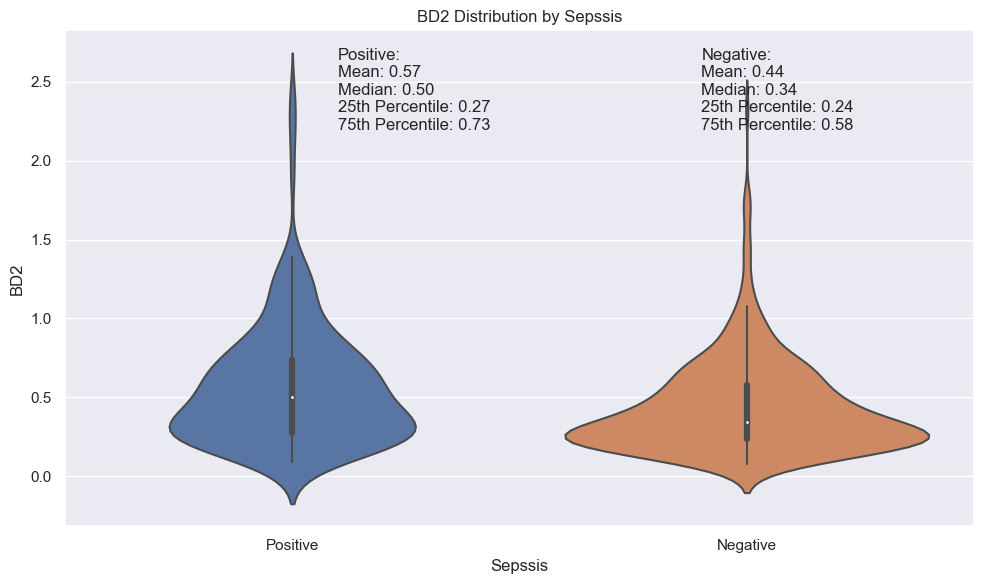

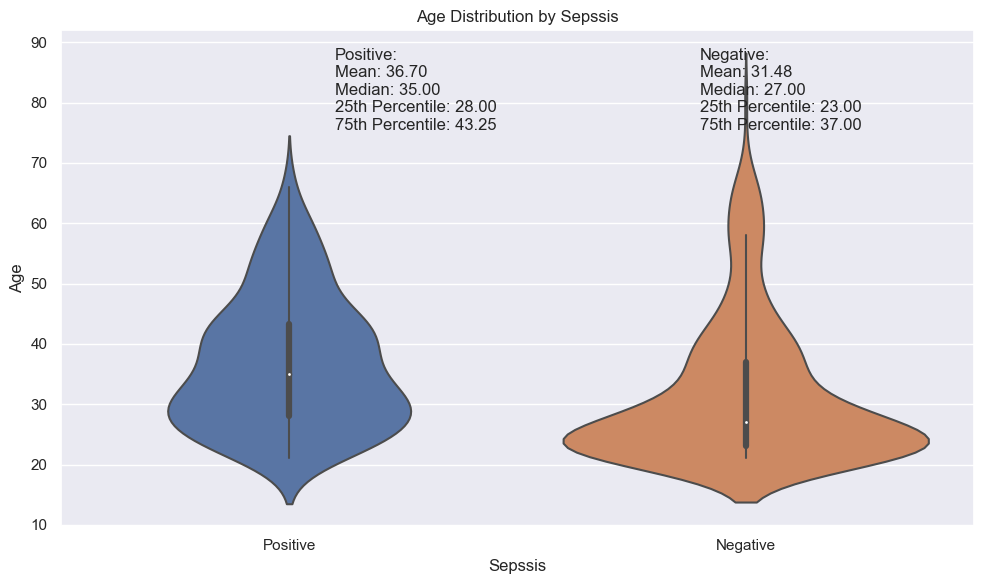

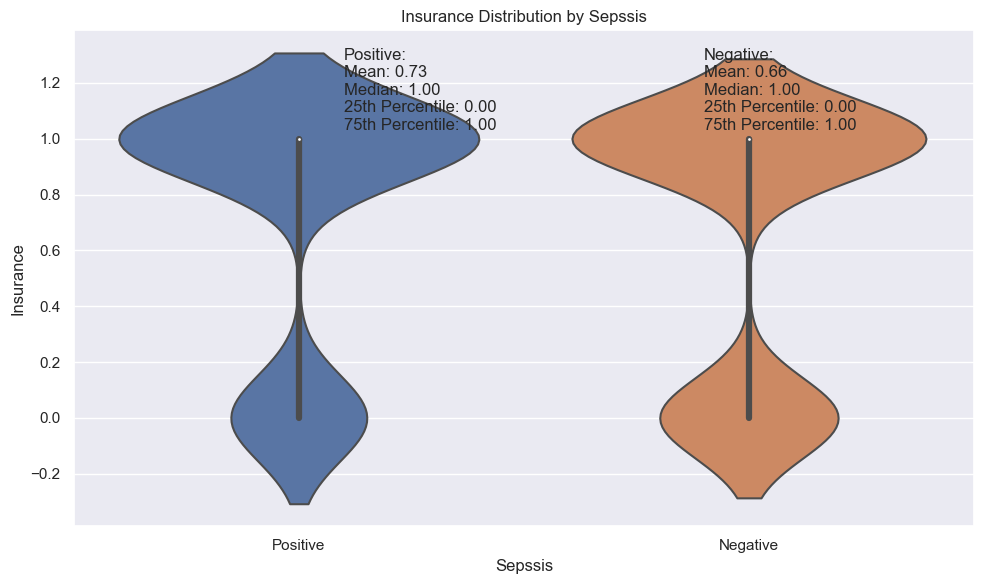

In [18]:
# Numerical Variables - Violin plots with statistics
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_tr, x='Sepssis', y=var)
    plt.xlabel('Sepssis')
    plt.ylabel(var)
    plt.title(f'{var} Distribution by Sepssis')
    
    # Calculate statistics
    positive_vals = df_tr[df_tr['Sepssis'] == 'Positive'][var]
    negative_vals = df_tr[df_tr['Sepssis'] == 'Negative'][var]
    stat_dict = {
        'Positive': {
            'Mean': np.mean(positive_vals),
            'Median': np.median(positive_vals),
            '25th Percentile': np.percentile(positive_vals, 25),
            '75th Percentile': np.percentile(positive_vals, 75)
        },
        'Negative': {
            'Mean': np.mean(negative_vals),
            'Median': np.median(negative_vals),
            '25th Percentile': np.percentile(negative_vals, 25),
            '75th Percentile': np.percentile(negative_vals, 75)
        }
    }
    
    # Add statistics as text annotations
    plt.text(0.30, 0.8, f"Positive:\nMean: {stat_dict['Positive']['Mean']:.2f}\nMedian: {stat_dict['Positive']['Median']:.2f}\n25th Percentile: {stat_dict['Positive']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Positive']['75th Percentile']:.2f}", transform=plt.gca().transAxes)
    plt.text(0.70, 0.8, f"Negative:\nMean: {stat_dict['Negative']['Mean']:.2f}\nMedian: {stat_dict['Negative']['Median']:.2f}\n25th Percentile: {stat_dict['Negative']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Negative']['75th Percentile']:.2f}", transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()



In [19]:
# Calculate correlation coefficients
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df_tr[numerical_vars + ['Sepssis_Encoded']].corr()

# Print correlation coefficients
for var in numerical_vars:
    correlation = correlations.loc[var, 'Sepssis_Encoded']
    print(f"Pearson correlation between 'Sepssis_Encoded' and '{var}': {correlation:.2f}")


Pearson correlation between 'Sepssis_Encoded' and 'PRG': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'PL': 0.45
Pearson correlation between 'Sepssis_Encoded' and 'PR': 0.06
Pearson correlation between 'Sepssis_Encoded' and 'SK': 0.08
Pearson correlation between 'Sepssis_Encoded' and 'TS': 0.15
Pearson correlation between 'Sepssis_Encoded' and 'M11': 0.32
Pearson correlation between 'Sepssis_Encoded' and 'BD2': 0.18
Pearson correlation between 'Sepssis_Encoded' and 'Age': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'Insurance': 0.06


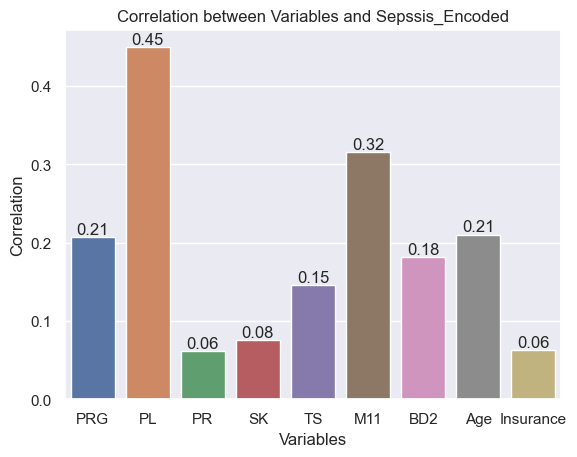

In [20]:
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df_tr[numerical_vars + ['Sepssis_Encoded']].corr()

# Get correlation values
correlation_values = correlations.loc[numerical_vars, 'Sepssis_Encoded']

# Create bar plot using Seaborn
sns.barplot(x=numerical_vars, y=correlation_values)

# Add data labels to the bar plot
for i, val in enumerate(correlation_values):
    plt.text(i, val, round(val, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Correlation between Variables and Sepssis_Encoded')

# Show the plot
plt.show()

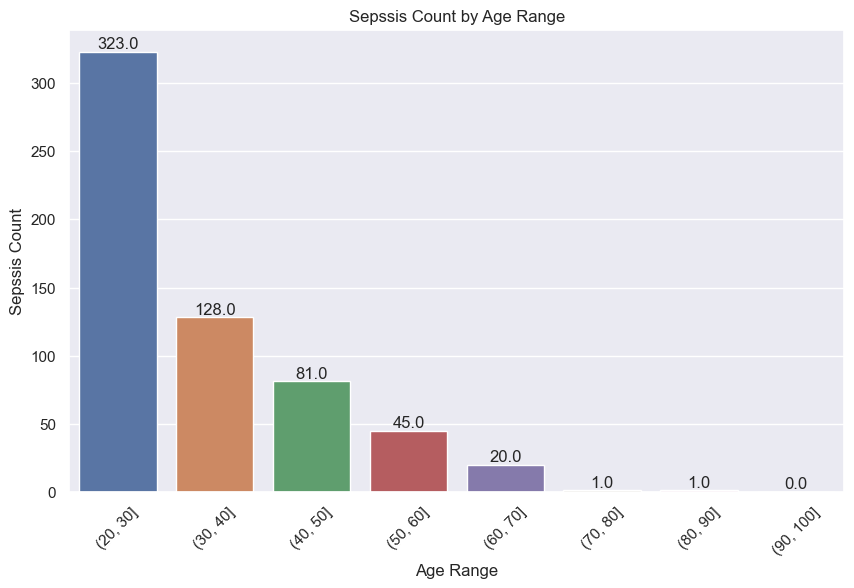

In [21]:
# Assuming your dataset is stored in a DataFrame called 'df'
age_ranges = pd.cut(df_tr['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100])
grouped_data = df_tr.groupby(age_ranges)

# Calculate the count of 'Sepssis' for each age range
count_sepsis_by_age = grouped_data['Sepssis'].count().reset_index()

# Plotting the count of 'Sepssis' for each age range
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=count_sepsis_by_age, x='Age', y='Sepssis')
ax.set(xlabel='Age Range', ylabel='Sepssis Count', title='Sepssis Count by Age Range')
plt.xticks(rotation=45)

# Add data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

## MULTIVARIATE ANALYSIS

### Correlation between the columns in the Train dataset

In [22]:
# Dropping column with data type as object
df1 = df_tr.copy()
df1.drop('Sepssis', axis=1, inplace=True)

In [23]:

# find the correlation between the columns
corr_matrix = df1.corr()
corr_matrix

PRG        PL        PR        SK        TS       M11  \
PRG              1.000000  0.139541  0.116680 -0.080902 -0.054812  0.033482   
PL               0.139541  1.000000  0.143064  0.054430  0.339818  0.215949   
PR               0.116680  0.143064  1.000000  0.197535  0.095281  0.269482   
SK              -0.080902  0.054430  0.197535  1.000000  0.429068  0.377950   
TS              -0.054812  0.339818  0.095281  0.429068  1.000000  0.184747   
M11              0.033482  0.215949  0.269482  0.377950  0.184747  1.000000   
BD2             -0.052230  0.144665  0.008318  0.176592  0.218313  0.127675   
Age              0.532545  0.274057  0.225625 -0.121553 -0.011523  0.046117   
Insurance        0.084631  0.050993 -0.025365 -0.017360  0.041560  0.026826   
Sepssis_Encoded  0.207115  0.449719  0.061086  0.075585  0.145892  0.315894   

                      BD2       Age  Insurance  Sepssis_Encoded  
PRG             -0.052230  0.532545   0.084631         0.207115  
PL               0.144665  0.274057   0.050993         0.449719  
PR               0.008318  0.225625  -0.025365         0.061086  
SK               0.176592 -0.121553  -0.017360         0.075585  
TS               0.218313 -0.011523   0.041560         0.145892  
M11              0.127675  0.046117   0.026826         0.315894  
BD2              1.000000  0.033567   0.006114         0.181561  
Age              0.033567  1.000000   0.054368         0.210234  
Insurance        0.006114  0.054368   1.000000         0.062582  
Sepssis_Encoded  0.181561  0.210234   0.062582         1.000000

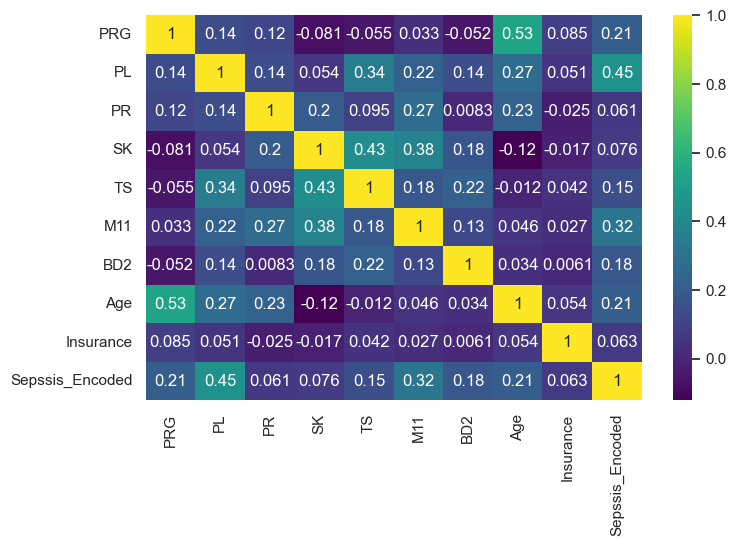

In [24]:
# Plot a heatmap for the correlations
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.show();

In [25]:
# Find the minimum correlation and corresponding columns
min_corr = corr_matrix.min().min()
min_corr_cols = []

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.index:
        if corr_matrix.loc[col1, col2] == min_corr:
            min_corr_cols.append((col1, col2))

print("Minimum Correlation:", min_corr)
print("Columns with Minimum Correlation:", min_corr_cols)

Minimum Correlation: -0.12155329275228288
Columns with Minimum Correlation: [('SK', 'Age'), ('Age', 'SK')]


In [26]:
# get the minimum value
max_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
            .max().max())  
# get the maximum value (excluding same columns)
# get the columns involved
max_corr_cols = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
                 .stack().idxmax()) 

print('The maximun correlation was:', max_corr)
print('The columns involved are:', max_corr_cols)

The maximun correlation was: 0.5325446086908504
The columns involved are: ('PRG', 'Age')


### Correlation between the columns in the Test dataset

In [27]:
# find the correlation between the columns
corr_matrix_t = df_ts.corr()
corr_matrix_t

PRG        PL        PR        SK        TS       M11  \
PRG        1.000000  0.088808  0.226032 -0.084315 -0.143327 -0.042980   
PL         0.088808  1.000000  0.184448  0.070199  0.296815  0.240396   
PR         0.226032  0.184448  1.000000  0.243956  0.064700  0.327511   
SK        -0.084315  0.070199  0.243956  1.000000  0.466503  0.450529   
TS        -0.143327  0.296815  0.064700  0.466503  1.000000  0.250437   
M11       -0.042980  0.240396  0.327511  0.450529  0.250437  1.000000   
BD2        0.041405  0.119497  0.179641  0.214038  0.051053  0.201224   
Age        0.587779  0.224456  0.292158 -0.086018 -0.159589 -0.001741   
Insurance  0.000742 -0.040125 -0.134804 -0.023332 -0.114407 -0.001815   

                BD2       Age  Insurance  
PRG        0.041405  0.587779   0.000742  
PL         0.119497  0.224456  -0.040125  
PR         0.179641  0.292158  -0.134804  
SK         0.214038 -0.086018  -0.023332  
TS         0.051053 -0.159589  -0.114407  
M11        0.201224 -0.001741  -0.001815  
BD2        1.000000  0.031738   0.094673  
Age        0.031738  1.000000  -0.013863  
Insurance  0.094673 -0.013863   1.000000

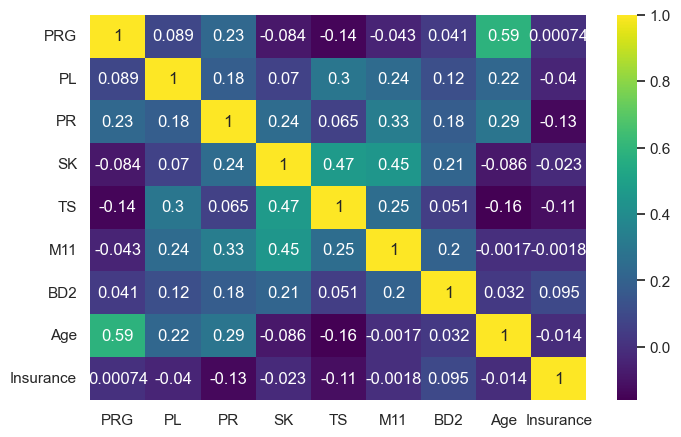

In [28]:
# Plot a heatmap for the correlations
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix_t, annot=True, cmap='viridis')
plt.show();

In [29]:
# Find the minimum correlation and corresponding columns
min_corr_t = corr_matrix_t.min().min()
min_corr_cols_t = []

for col1 in corr_matrix_t.columns:
    for col2 in corr_matrix_t.index:
        if corr_matrix_t.loc[col1, col2] == min_corr_t:
            min_corr_cols_t.append((col1, col2))

print("Minimum Correlation:", min_corr_t)
print("Columns with Minimum Correlation:", min_corr_cols_t)

Minimum Correlation: -0.15958934271107075
Columns with Minimum Correlation: [('TS', 'Age'), ('Age', 'TS')]


In [30]:
# get the maximum value
max_corr_t = (corr_matrix_t.where(np.triu(np.ones(corr_matrix_t.shape), k=1).astype(np.bool_))
            .max().max())  
# get the maximum value (excluding same columns)
# get the columns involved
max_corr_cols_t = (corr_matrix_t.where(np.triu(np.ones(corr_matrix_t.shape), k=1).astype(np.bool_))
                 .stack().idxmax()) 

print('The maximun correlation was:', max_corr_t)
print('The columns involved are:', max_corr_cols_t)

The maximun correlation was: 0.5877793041318986
The columns involved are: ('PRG', 'Age')


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


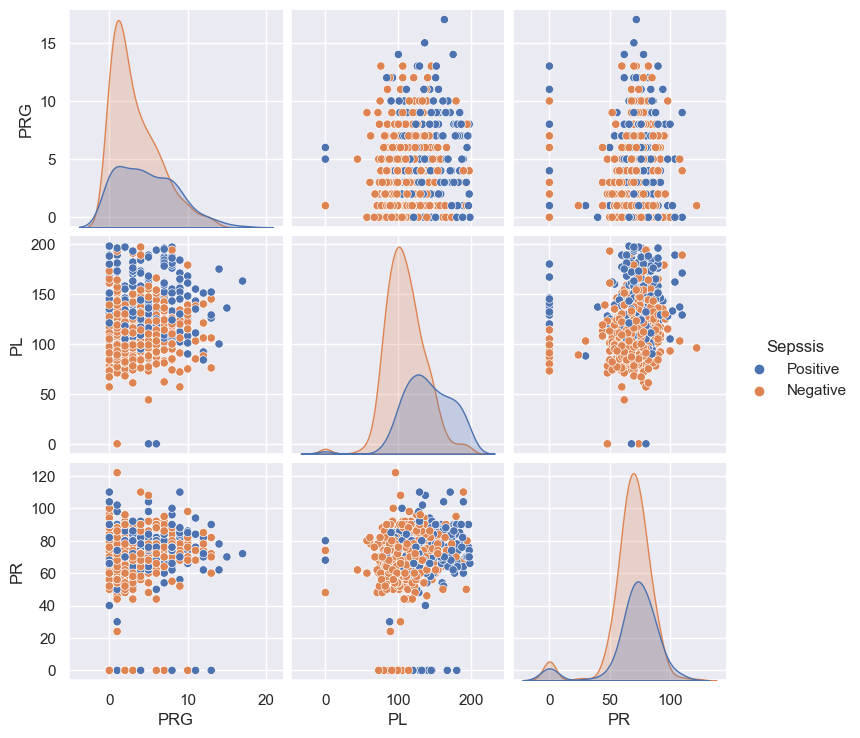

In [31]:
numerical_vars = ['PRG', 'PL', 'PR']
sns.pairplot(data=df_tr, vars=numerical_vars, hue='Sepssis')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


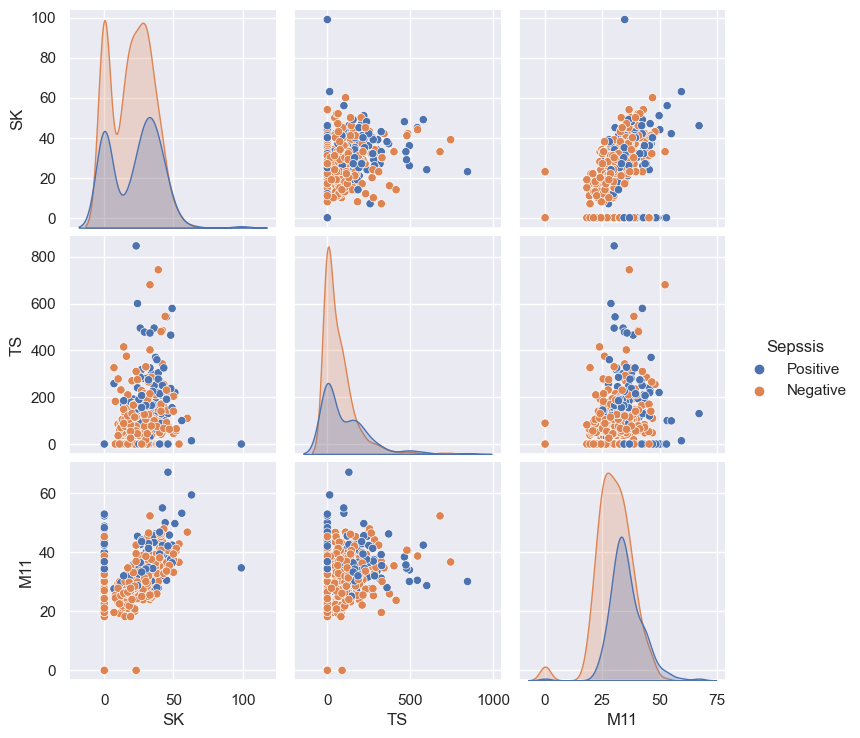

In [32]:
numerical_vars = ['SK', 'TS', 'M11']
sns.pairplot(data=df_tr, vars=numerical_vars, hue='Sepssis')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


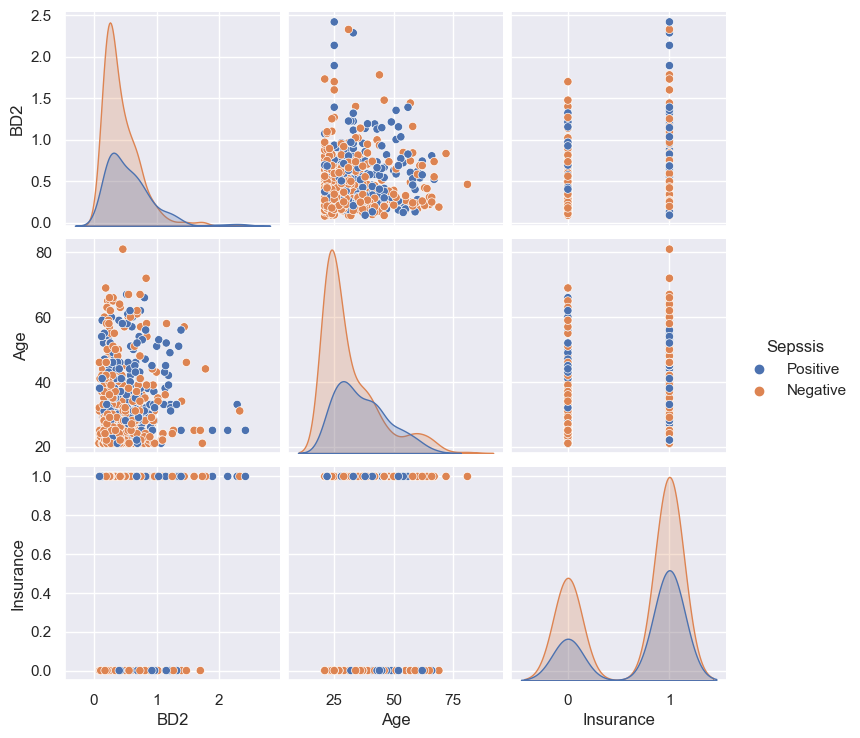

In [33]:
numerical_vars = ['BD2', 'Age', 'Insurance']
sns.pairplot(data=df_tr, vars=numerical_vars, hue='Sepssis')

## Hypothesis Testing

#### Hypothesis 1
- **Null Hypothesis (H0):** There is no significant difference in mean Plasma glucose levels (PRG) between patients with and without sepsis.
- **Alternate Hypothesis (H1):** There is a significant difference in mean Plasma glucose levels (PRG) between patients with and without sepsis.


T-statistic: 5.172721512358376
P-value: 3.154172341568826e-07


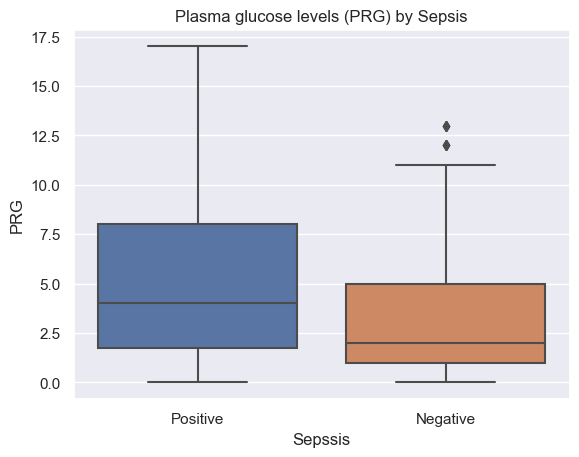

In [34]:
grouped_data = df_tr.groupby('Sepssis')

sepsis_yes = grouped_data.get_group('Positive')
sepsis_no = grouped_data.get_group('Negative')

sepsis_yes_prg = sepsis_yes['PRG']
sepsis_no_prg = sepsis_no['PRG']

t_stat, p_value = stats.ttest_ind(sepsis_yes_prg, sepsis_no_prg)

print("T-statistic:", t_stat)
print("P-value:", p_value)

sns.boxplot(x='Sepssis', y='PRG', data=df_tr)
plt.title("Plasma glucose levels (PRG) by Sepsis")
plt.show()

##### **Conclusion**
- The t-statistic value is approximately 5.17, and the p-value is significantly smaller than the typical significance level (e.g., 0.05), indicating that the difference in mean Plasma glucose levels (PRG) between patients with and without sepsis is statistically significant.

- Therefore, we reject the null hypothesis (H0) and conclude that there is a significant difference in mean Plasma glucose levels between patients with and without sepsis.

- In conclusion, the results suggest that the mean Plasma glucose levels (PRG) are different between patients with and without sepsis, and this difference is unlikely to have occurred by chance. The boxplot visualization also supports this conclusion, as there seems to be a noticeable difference in the distribution of PRG values between the two groups

#### Hypothesis 2:
- **Null Hypothesis (H0):**
 There is no significant correlation between Blood Pressure (PR) and Body mass index (M11).
- **Alternate Hypothesis (H1):** There is a significant correlation between Blood Pressure (PR) and Body mass index (M11).

Correlation Coefficient: 0.2694817900679736
P-value: 1.9989399562103356e-11


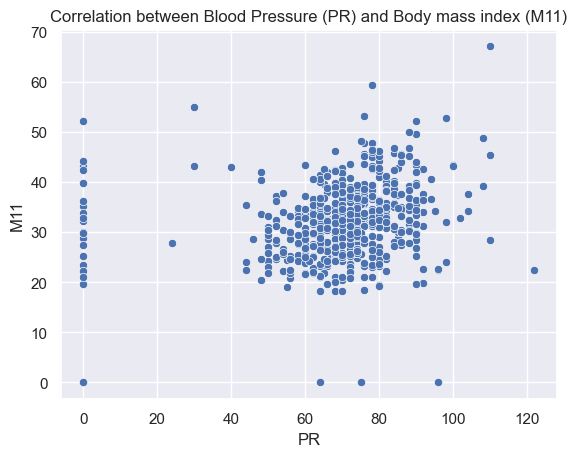

In [35]:
correlation_coefficient, p_value = stats.pearsonr(df_tr['PR'], df_tr['M11'])

print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

sns.scatterplot(x='PR', y='M11', data=df_tr)
plt.title("Correlation between Blood Pressure (PR) and Body mass index (M11)")
plt.show()

##### **Conclusion**
- The correlation coefficient between Blood Pressure (PR) and Body mass index (M11) is approximately 0.27, which indicates a positive correlation between the two variables. A positive correlation means that as one variable increases, the other tends to increase as well.

- The p-value is very small, much smaller than the typical significance level (e.g., 0.05), indicating that the correlation is statistically significant. Therefore, we reject the null hypothesis (H0) and conclude that there is a significant positive correlation between Blood Pressure and Body mass index.

- It can be concluded that, the results suggest that there is a meaningful relationship between Blood Pressure and Body mass index in the dataset, and the strength of this relationship is moderate (correlation coefficient ≈ 0.27)

#### Hypothesis 3:
- **Null Hypothesis (H0):** The distribution of Blood Work Result-1 (PL) is the same for patients with and without valid insurance.
- **Alternate Hypothesis (H1):** The distribution of Blood Work Result-1 (PL) is different for patients with and without valid insurance.

U-statistic: 41481.0
P-value: 0.14753285682539402


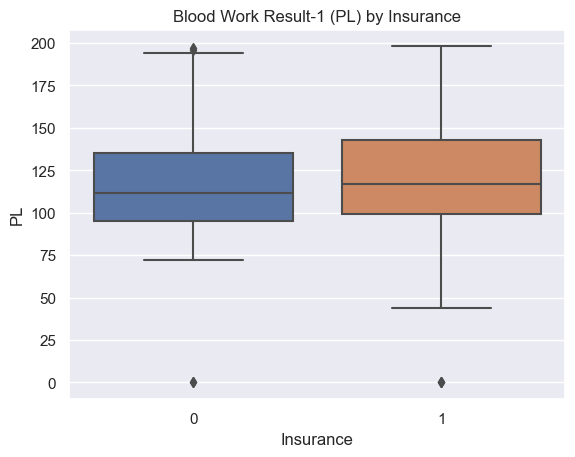

In [36]:
insurance_yes = df_tr[df_tr['Insurance'] == 1]['PL']
insurance_no = df_tr[df_tr['Insurance'] == 0]['PL']

U_stat, p_value = stats.mannwhitneyu(insurance_yes, insurance_no, alternative='two-sided')

print("U-statistic:", U_stat)
print("P-value:", p_value)

sns.boxplot(x='Insurance', y='PL', data=df_tr)
plt.title("Blood Work Result-1 (PL) by Insurance")
plt.show()

##### **Conclusion**
- The Mann-Whitney U test (Wilcoxon rank-sum test) has been used to compare the distribution of Blood Work Result-1 (PL) between patients with and without valid insurance.

- The U-statistic is 41481.0, and the p-value is approximately 0.1475. The p-value is greater than the typical significance level (e.g., 0.05), indicating that we do not have enough evidence to reject the null hypothesis.

- Therefore, we fail to reject the null hypothesis (H0), and we conclude that there is no significant difference in the distribution of Blood Work Result-1 (PL) between patients with and without valid insurance.

- In other words, the results suggest that the distribution of Blood Work Result-1 (PL) does not vary significantly between patients with and without valid insurance. The boxplot visualization also shows that the distributions have a similar shape and overlap considerably, further supporting this conclusion.

#### Hypothesis 4:
- **Null Hypothesis (H0):** The mean age of patients with sepsis is the same as the mean age of patients without sepsis.
- **Alternate Hypothesis (H1):** The mean age of patients with sepsis is different from the mean age of patients without sepsis.

T-statistic: 5.398028835705048
P-value: 1.085959278630566e-07


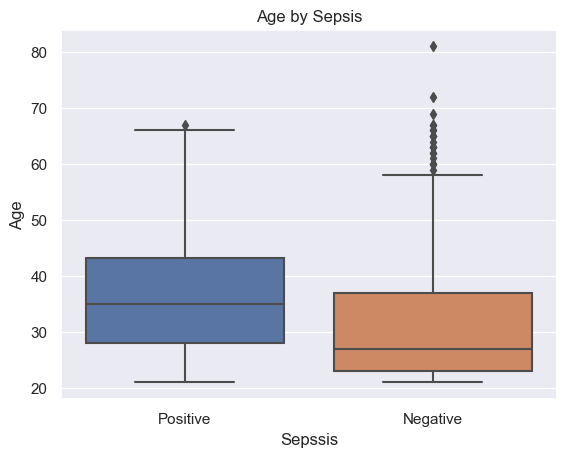

In [37]:
sepsis_yes = df_tr[df_tr['Sepssis'] == 'Positive']['Age']
sepsis_no = df_tr[df_tr['Sepssis'] == 'Negative']['Age']

t_stat, p_value = stats.ttest_ind(sepsis_yes, sepsis_no, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

sns.boxplot(x='Sepssis', y='Age', data=df_tr)
plt.title("Age by Sepsis")
plt.show()

##### **Conclusion**
- The t-statistic value is approximately 5.40, and the p-value is significantly smaller than the typical significance level (e.g., 0.05). This indicates that the difference in mean age between patients with and without sepsis is statistically significant.

- Therefore, we reject the null hypothesis (H0) and conclude that there is a significant difference in mean age between patients with and without sepsis.

- In conclusion, the results suggest that the mean age of patients with sepsis is different from the mean age of patients without sepsis, and this difference is unlikely to have occurred by chance. The boxplot visualization also supports this conclusion, as there seems to be a noticeable difference in the distribution of ages between the two groups.

#### Hypothesis 5:
- **Null Hypothesis (H0):** There is no significant difference in Blood Work Result-4 (BD2) between patients with and without valid insurance.
- **Alternate Hypothesis (H1):** There is a significant difference in Blood Work Result-4 (BD2) between patients with and without valid insurance.

T-statistic: 0.15771644627762355
P-value: 0.8747568716697852


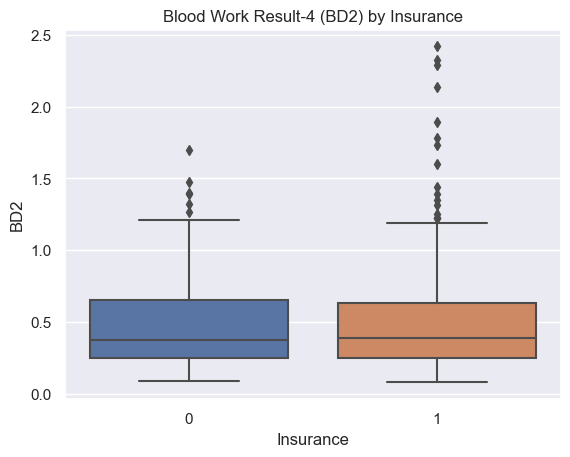

In [38]:
insurance_yes = df_tr[df_tr['Insurance'] == 1]['BD2']
insurance_no = df_tr[df_tr['Insurance'] == 0]['BD2']

t_stat, p_value = stats.ttest_ind(insurance_yes, insurance_no, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

sns.boxplot(x='Insurance', y='BD2', data=df_tr)
plt.title("Blood Work Result-4 (BD2) by Insurance")
plt.show()

##### **Conclusion**
- The t-statistic value is approximately 0.16, and the p-value is greater than the typical significance level (e.g., 0.05). This indicates that we do not have enough evidence to reject the null hypothesis.

- Therefore, we fail to reject the null hypothesis (H0), and we conclude that there is no significant difference in Blood Work Result-4 (BD2) between patients with and without valid insurance.

- In conclusion, the results suggest that the mean Blood Work Result-4 (BD2) is not significantly different between patients with and without valid insurance. The boxplot visualization also shows that the distributions have a similar shape and overlap considerably, further supporting this conclusion.

- It's important to note that the high p-value indicates that the difference between the two groups is likely due to random variation rather than a meaningful difference. This lack of significant difference suggests that Blood Work Result-4 (BD2) may not be associated with insurance status in this dataset. 

In [39]:
# 1. replace zero values in dataset with either mean or median #
# 2. do over sampling 
# 3. feature scaling

# Feature Processing & Engineering

### Data Preprocessing

In [40]:
def check_missing_values(data):
    missing_values = data.isna().sum()
    print("Missing values:\n", missing_values)

In [41]:
# Check missing values in train data
check_missing_values(df_tr)

# Check missing values in test data
check_missing_values(df_ts)

Missing values:
 PRG                0
PL                 0
PR                 0
SK                 0
TS                 0
M11                0
BD2                0
Age                0
Insurance          0
Sepssis            0
Sepssis_Encoded    0
dtype: int64
Missing values:
 PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64


#### Checking Imbalance in Target Column 

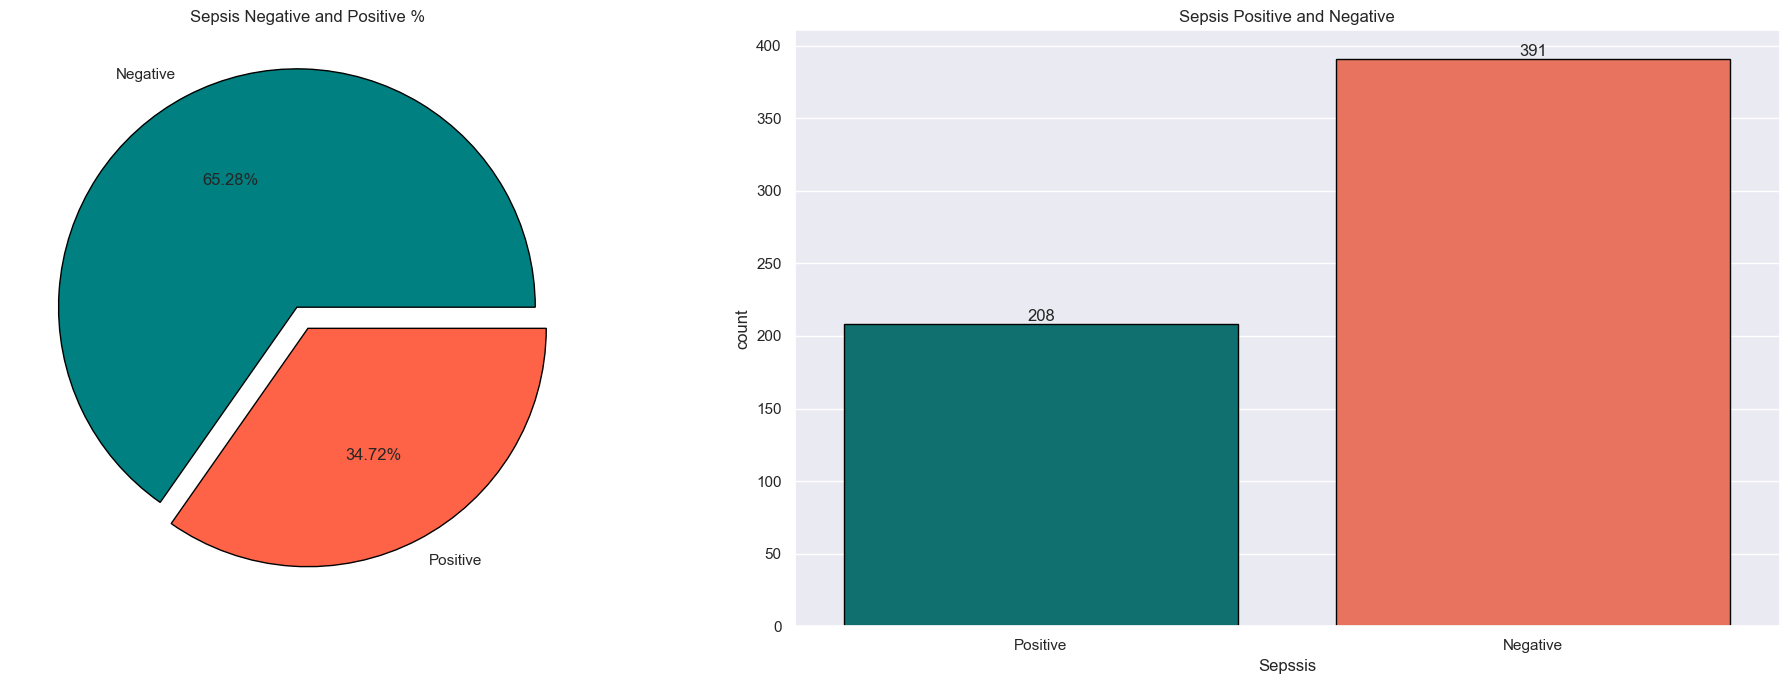

In [42]:
# Define colors for the plots
palette = ['#008080', '#FF6347', '#E50000', '#D2691E']

# Calculate the percentage of positive and negative values
sepsis_counts = df_tr['Sepssis_Encoded'].value_counts()
pie_values = [sepsis_counts[0] / sepsis_counts.sum() * 100, sepsis_counts[1] / sepsis_counts.sum() * 100]

# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot the pie chart on the first subplot
axes[0].pie(pie_values, labels=['Negative', 'Positive'], autopct='%1.2f%%', explode=(0.1, 0),
            colors=palette[:2], wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[0].set_title('Sepsis Negative and Positive %')

# Plot the countplot on the second subplot
sns.countplot(data=df_tr, x='Sepssis', palette=palette[:2], edgecolor='black', ax=axes[1])
axes[1].set_xticklabels(['Positive', 'Negative'])
axes[1].set_title('Sepsis Positive and Negative')

# Add labels to the countplot bars
for container in axes[1].containers:
    axes[1].bar_label(container)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

- Sepsis column is not balance as shown in the diagram above, where positive sepsis is 208 that is 34.72% and negative is 391 which is 66.28%

In [43]:
df.drop('ID', axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PRG        599 non-null    int64  
 1   PL         599 non-null    int64  
 2   PR         599 non-null    int64  
 3   SK         599 non-null    int64  
 4   TS         599 non-null    int64  
 5   M11        599 non-null    float64
 6   BD2        599 non-null    float64
 7   Age        599 non-null    int64  
 8   Insurance  599 non-null    int64  
 9   Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 46.9+ KB


#### TARGET ENCODING

In [44]:
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(df['Sepssis'])
target_encoded = pd.DataFrame(encoded_target, columns=['Sepssis'])

In [45]:
train_encoded = pd.concat([df.iloc[:, :-1], target_encoded], axis=1)
train_encoded.head()

PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance  Sepssis
0    6  148  72  35    0  33.6  0.627   50          0        1
1    1   85  66  29    0  26.6  0.351   31          0        0
2    8  183  64   0    0  23.3  0.672   32          1        1
3    1   89  66  23   94  28.1  0.167   21          1        0
4    0  137  40  35  168  43.1  2.288   33          1        1

#### DATA SPLITING

In [46]:
# split train+validation set into training and validation sets
X_train, X_eval, y_train, y_eval = train_test_split(train_encoded.iloc[:, :-1], train_encoded.iloc[:, -1:], test_size=0.2, random_state=42, stratify=train_encoded.iloc[:, -1:])

# Print the shapes of the train and validation sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)

X_train shape: (479, 9)
y_train shape: (479, 1)
X_eval shape: (120, 9)
y_eval shape: (120, 1)


#### IMPUTATION

In [47]:
# Creating imputer variables
numerical_imputer = SimpleImputer(strategy = "mean")
X_train_imputer = numerical_imputer.fit_transform(X_train)
X_eval_imputer = numerical_imputer.transform(X_eval)
test_impurter = numerical_imputer.transform(df_ts)

#### SCALING

In [48]:
scaler = StandardScaler()
X_train_df = scaler.fit_transform(X_train_imputer)
X_eval_df = scaler.fit_transform(X_eval_imputer)
test_df = scaler.fit_transform(test_impurter)

#### CUSTOM ML FUNCTIONS

In [50]:
# Confusion Matrix Function
def plot_metric(confusion, name):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
    confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
    confusion.flatten()/np.sum(confusion)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='viridis')
    ax.set_title(f'{name}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [51]:
# Function for Training Models

def train_ml_model(X_train, y_train, X_eval, y_eval, model_class, **model_params):
    """
    Train a machine learning model, calculate various metrics, generate an ROC curve,
    and return results in a DataFrame.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_eval: Evaluation features
    - y_eval: Evaluation labels
    - model_class: Class of the machine learning model to be used (e.g., LogisticRegression)
    - **model_params: Additional parameters for the model constructor

    Returns:
    - result_df: DataFrame containing model, predictions, F1-score, FPR, TPR, thresholds, and AUC-score
    """
    
    results = []  # List to store results for each model

    # Initialize the model
    model = model_class(**model_params)
    model.fit(X_train, y_train)

    # Make predictions on the evaluation set
    predictions = model.predict(X_eval)

    # Calculate F1 score
    f1 = round(f1_score(y_eval, predictions), 2)

    # Make predictions on the training and evaluation sets
    train_preds = model.predict(X_train)
    eval_preds = model.predict(X_eval)

    # Calculate F1-score for training and evaluation sets
    train_f1 = f1_score(y_train, train_preds)
    eval_f1 = f1_score(y_eval, eval_preds)

    # Determine if the model is overfitting, underfitting, or balanced
    if train_f1 > eval_f1:
        assessment = "Overfitting"
    elif train_f1 < eval_f1:
        assessment = "Underfitting"
    else:
        assessment = "Balanced"
    
    # Calculate and Plot confusion matrix
    confusion = confusion_matrix(y_eval, predictions)
    plot_metric(confusion, model_class())

    # Calculate false positive rate, true positive rate, and thresholds using roc_curve
    fpr, tpr, thresholds = roc_curve(y_eval, predictions)

    # Calculate AUC score
    auc = round(roc_auc_score(y_eval, predictions), 2)

    # Create ROC curve plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Create a DataFrame to store the results
    result_data = {
        'Model': model_class.__name__,  # Using the model class name as the identifier,
        #'Predictions': [predictions],
        'F1-Score': f1,
        #'FPR': [fpr],
        #'TPR': [tpr],
        #'Thresholds': [thresholds],
        'AUC-Score': auc,
        'Assessment': assessment
    }

    results.append(result_data)

    result_df = pd.DataFrame(results)

    return result_df

### Training ML Model with Unbalanced Dataset

#### Model 1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


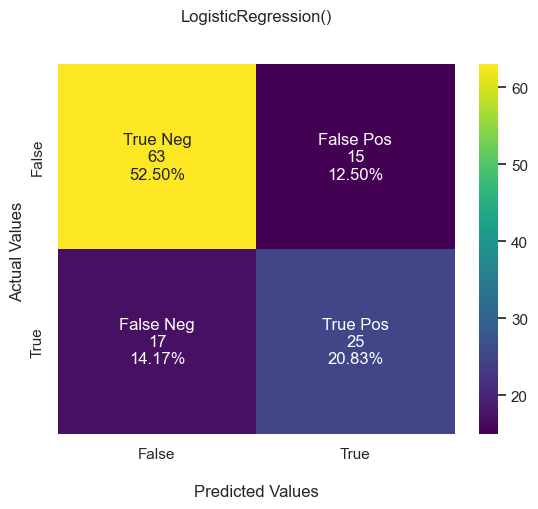

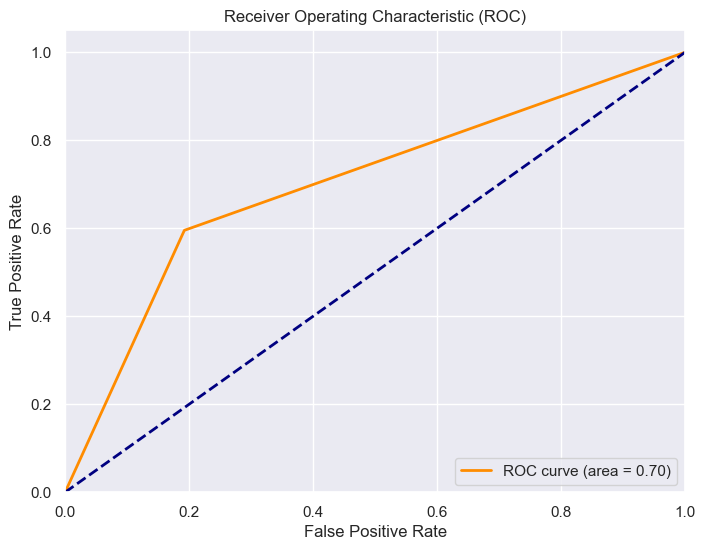

Model  F1-Score  AUC-Score   Assessment
0  LogisticRegression      0.61        0.7  Overfitting

In [52]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, LogisticRegression, random_state=42)
lr = result_df
lr

#### Model 2

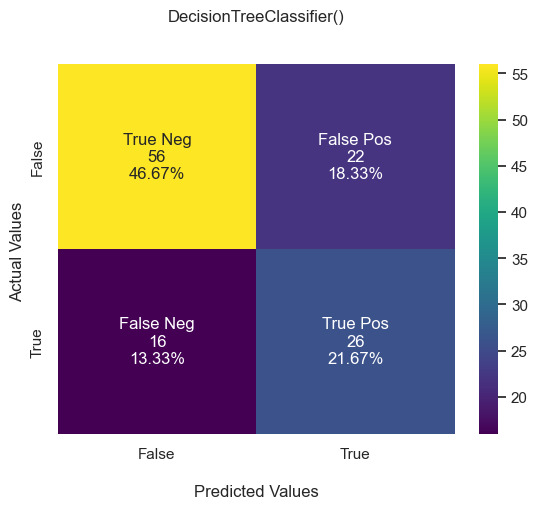

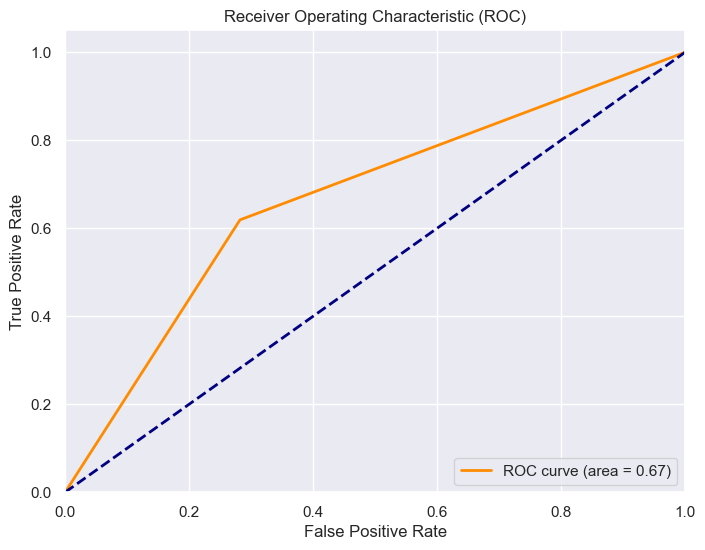

Model  F1-Score  AUC-Score   Assessment
0  DecisionTreeClassifier      0.58       0.67  Overfitting

In [53]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, DecisionTreeClassifier, random_state=42)
dt = result_df
dt

#### Model 3

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


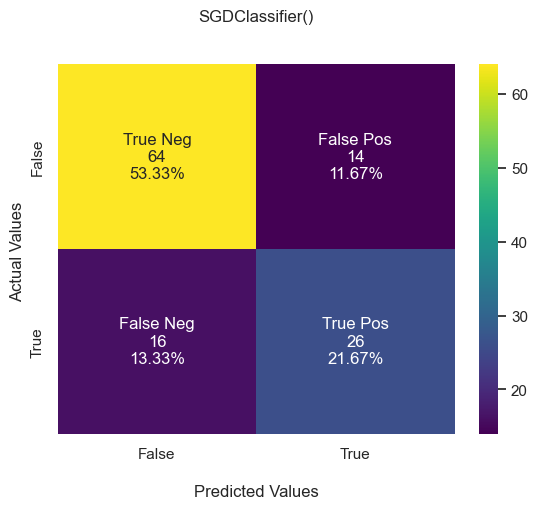

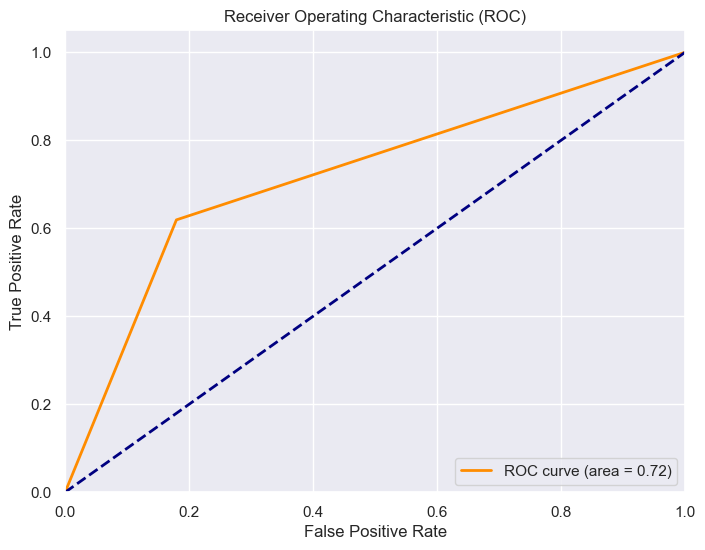

Model  F1-Score  AUC-Score    Assessment
0  SGDClassifier      0.63       0.72  Underfitting

In [54]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, SGDClassifier, random_state=42)
sgd = result_df
sgd

In [55]:
#lgb_model = LGBMClassifier(random_state=42)
#result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, lgb_model)

#### Model 4

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


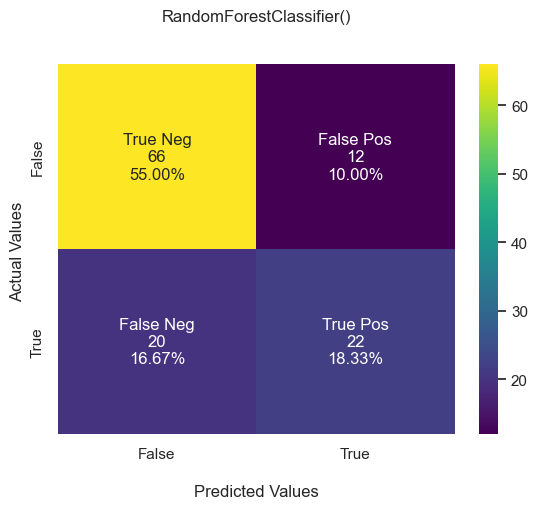

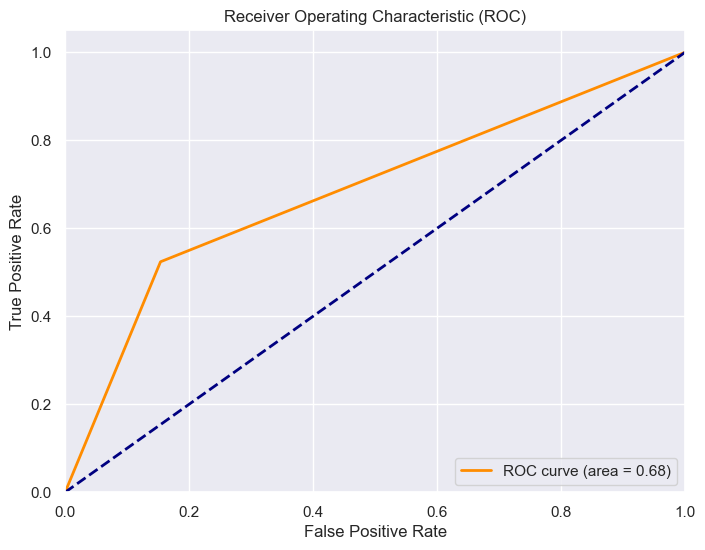

Model  F1-Score  AUC-Score   Assessment
0  RandomForestClassifier      0.58       0.68  Overfitting

In [56]:
#rf_model = RandomForestClassifier(random_state=42)
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, RandomForestClassifier, random_state=42)
rf = result_df
rf

#### Model 5

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


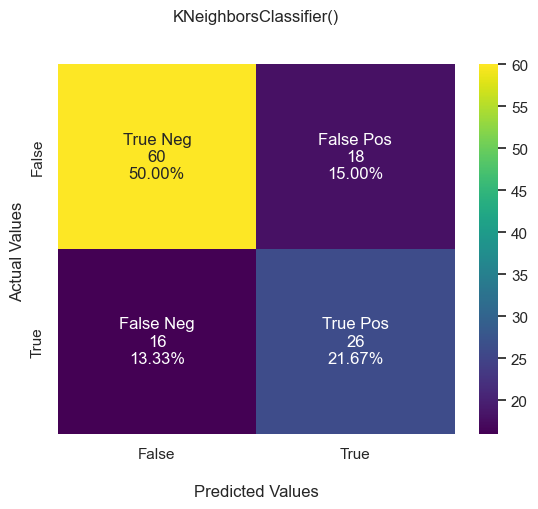

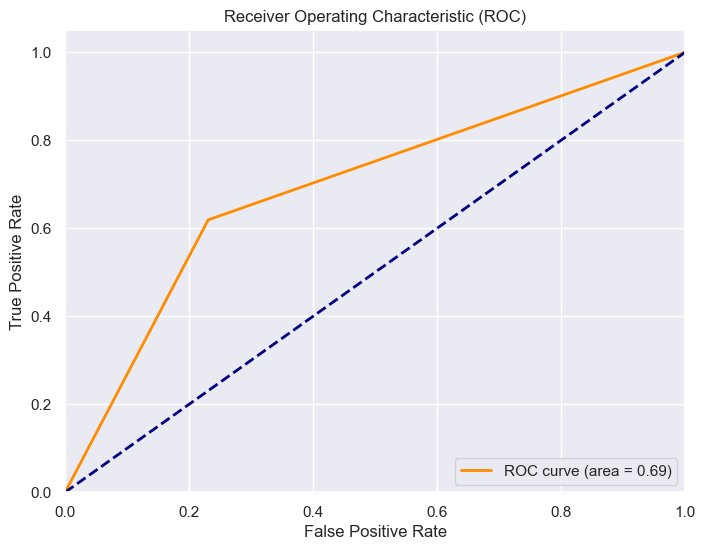

Model  F1-Score  AUC-Score   Assessment
0  KNeighborsClassifier       0.6       0.69  Overfitting

In [57]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, KNeighborsClassifier)
knn = result_df
knn

#### Model 6

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


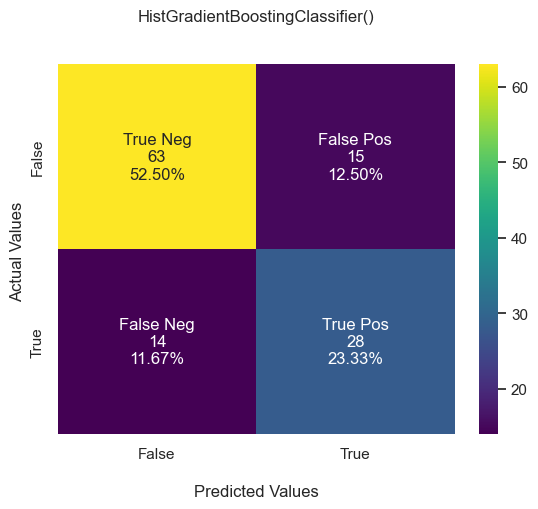

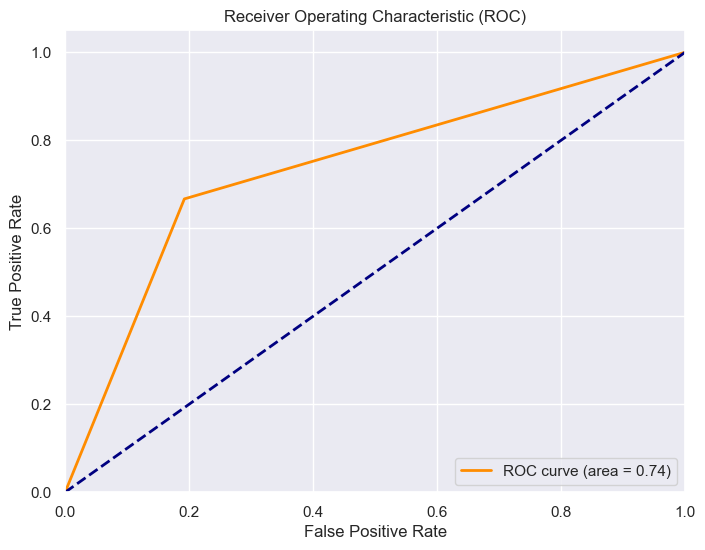

Model  F1-Score  AUC-Score   Assessment
0  HistGradientBoostingClassifier      0.66       0.74  Overfitting

In [58]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, HistGradientBoostingClassifier, random_state=42)
hgb = result_df
hgb

#### Model 7

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


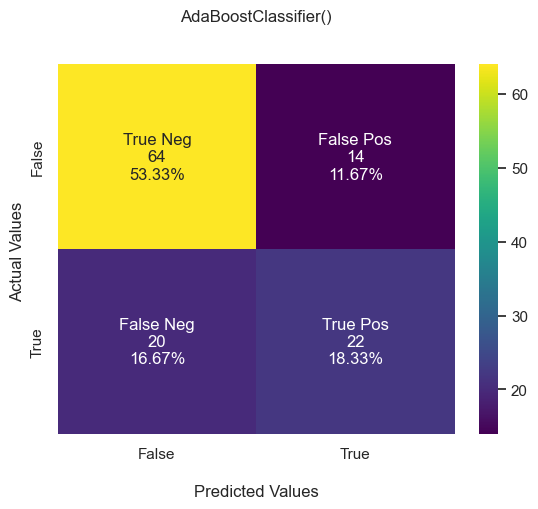

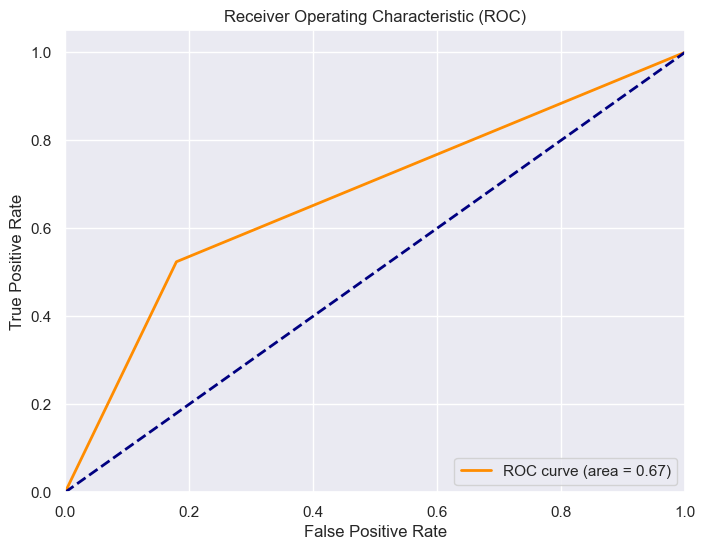

Model  F1-Score  AUC-Score   Assessment
0  AdaBoostClassifier      0.56       0.67  Overfitting

In [59]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, AdaBoostClassifier, random_state=42)
adb = result_df
adb

### Models Comparison For UnBalanced Dataset

In [60]:
results= {'model':['Decision Tree','Random Forest','AdaBoost','Logistic Regression','KNeighbors','HistGradientBoosting','SGBoost'],
         'f1_score':[dt['F1-Score'].iloc[0],rf['F1-Score'].iloc[0],lr['F1-Score'].iloc[0],knn['F1-Score'].iloc[0],hgb['F1-Score'].iloc[0],
                    sgd['F1-Score'].iloc[0], adb['F1-Score'].iloc[0]],                  
         'AUC_score':[dt['AUC-Score'].iloc[0],rf['AUC-Score'].iloc[0],lr['AUC-Score'].iloc[0],knn['AUC-Score'].iloc[0],hgb['AUC-Score'].iloc[0],
                    sgd['AUC-Score'].iloc[0], adb['AUC-Score'].iloc[0]],
         'Assessment':[dt['Assessment'].iloc[0],rf['Assessment'].iloc[0],lr['Assessment'].iloc[0],knn['Assessment'].iloc[0],hgb['Assessment'].iloc[0],
                    sgd['Assessment'].iloc[0], adb['Assessment'].iloc[0]]
}

results_df= pd.DataFrame(results)
results_df = results_df.sort_values(by ='AUC_score', ascending =False)
results_df

model  f1_score  AUC_score    Assessment
4            KNeighbors      0.66       0.74   Overfitting
5  HistGradientBoosting      0.63       0.72  Underfitting
2              AdaBoost      0.61       0.70   Overfitting
3   Logistic Regression      0.60       0.69   Overfitting
1         Random Forest      0.58       0.68   Overfitting
0         Decision Tree      0.58       0.67   Overfitting
6               SGBoost      0.56       0.67   Overfitting

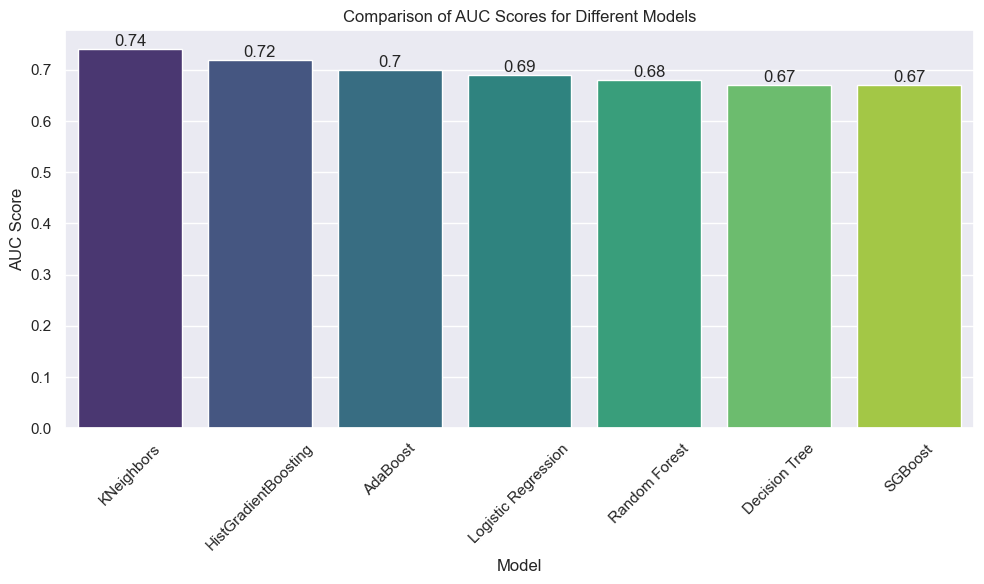

In [61]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='model', y='AUC_score', palette='viridis')

# Add data labels
for i, value in enumerate(results_df['AUC_score']):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')

# Set other plot properties
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models')
plt.tight_layout()
plt.show()

### Training of ML Models with balanced dataset

### Balancing Traning Dataset

In [62]:
# Use Over-sampling/Under-sampling methods, more details here: https://imbalanced-learn.org/stable/install.html
oversample= SMOTE()
X_train_resampled,y_train_resampled = oversample.fit_resample(X_train_df, y_train)
X_train_resampled.shape,y_train_resampled.shape

((626, 9), (626, 1))

#### Balanced Model 1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


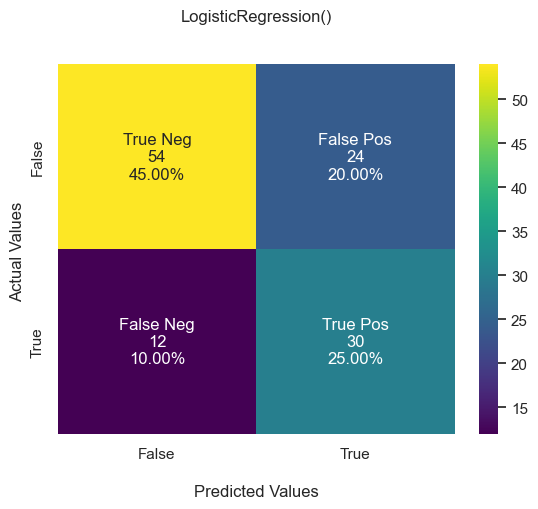

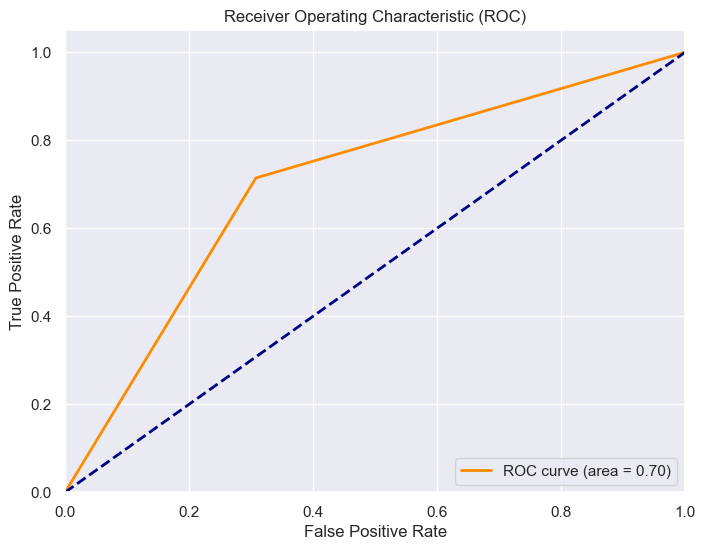

Model  F1-Score  AUC-Score   Assessment
0  LogisticRegression      0.63        0.7  Overfitting

In [63]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, LogisticRegression, random_state=42)
lr_RE = result_df
lr_RE

#### Balanced Model 2

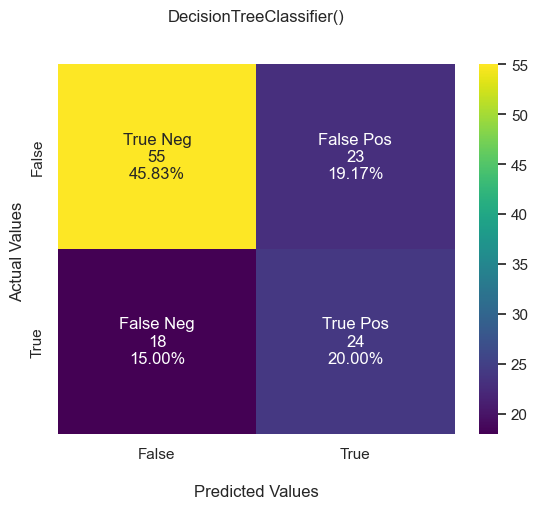

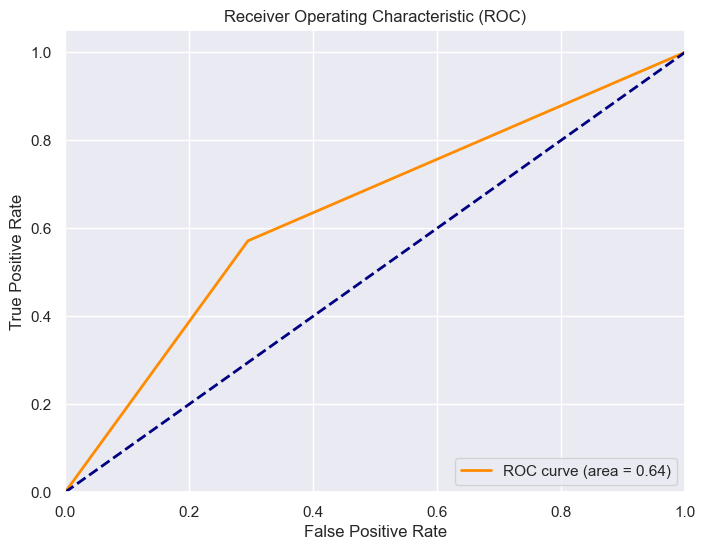

Model  F1-Score  AUC-Score   Assessment
0  DecisionTreeClassifier      0.54       0.64  Overfitting

In [64]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, DecisionTreeClassifier, random_state=42)
dt_RE = result_df
dt_RE

#### Balanced Model 3

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


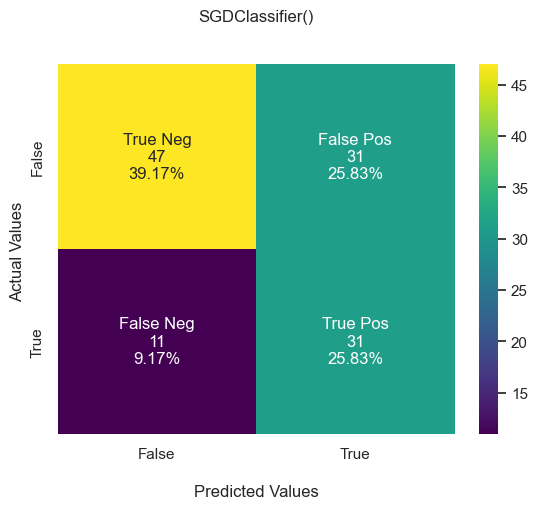

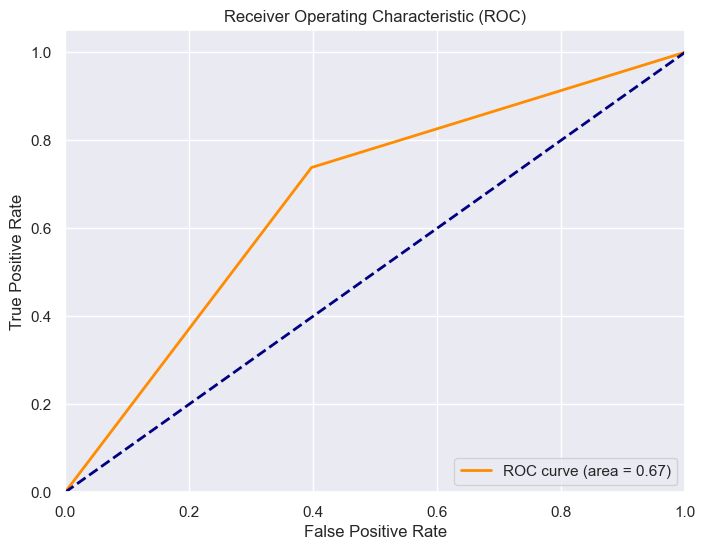

Model  F1-Score  AUC-Score   Assessment
0  SGDClassifier       0.6       0.67  Overfitting

In [65]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, SGDClassifier, random_state=42)
sgd_RE = result_df
sgd_RE

#### Balanced Model 4

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


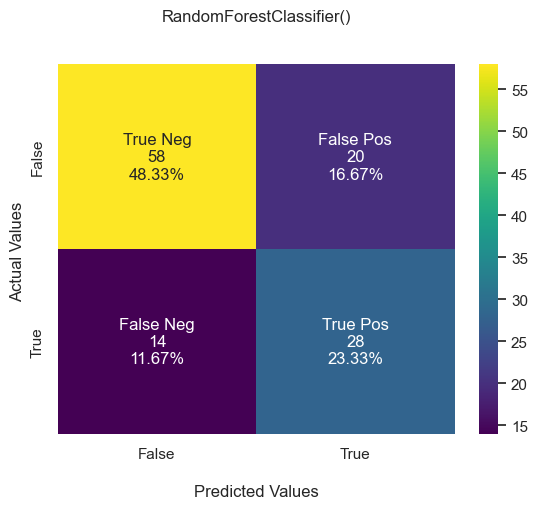

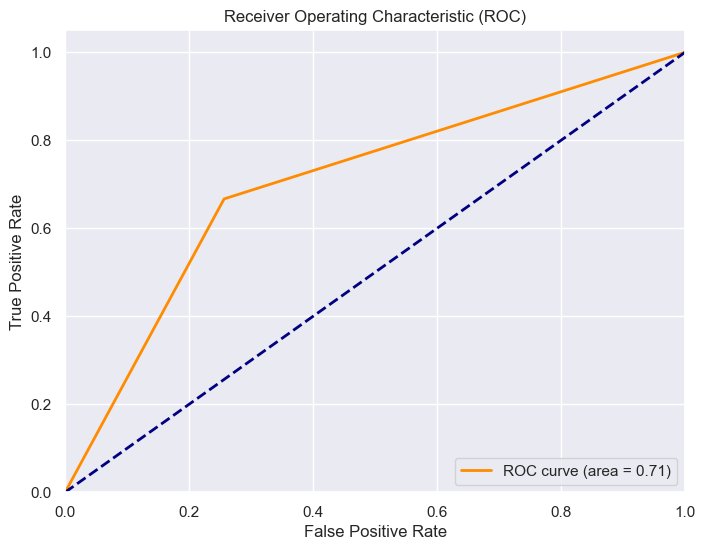

Model  F1-Score  AUC-Score   Assessment
0  RandomForestClassifier      0.62       0.71  Overfitting

In [66]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, RandomForestClassifier, random_state=42)
rf_RE = result_df
rf_RE

#### Balanced Model 5

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


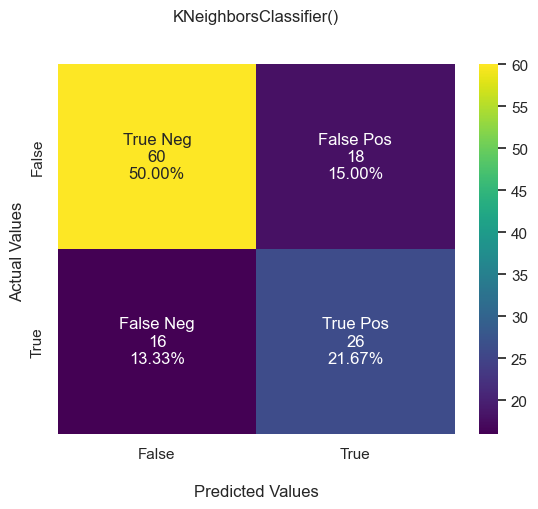

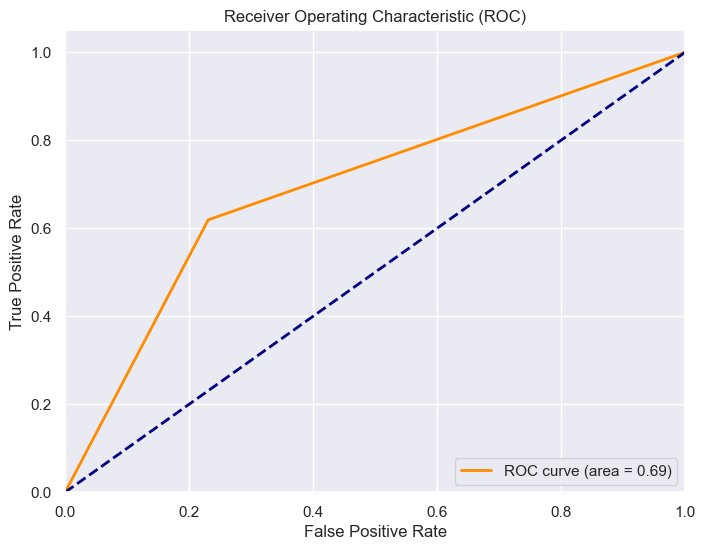

Model  F1-Score  AUC-Score   Assessment
0  KNeighborsClassifier       0.6       0.69  Overfitting

In [67]:
result_df = train_ml_model(X_train_df, y_train, X_eval_df, y_eval, KNeighborsClassifier)
knn_RE = result_df
knn_RE

#### Balanced Model 6

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


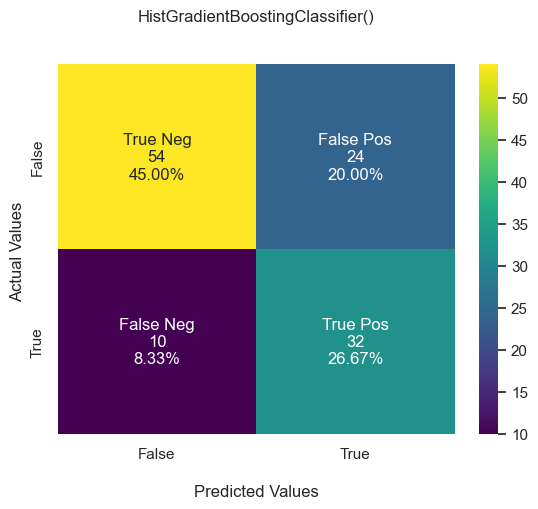

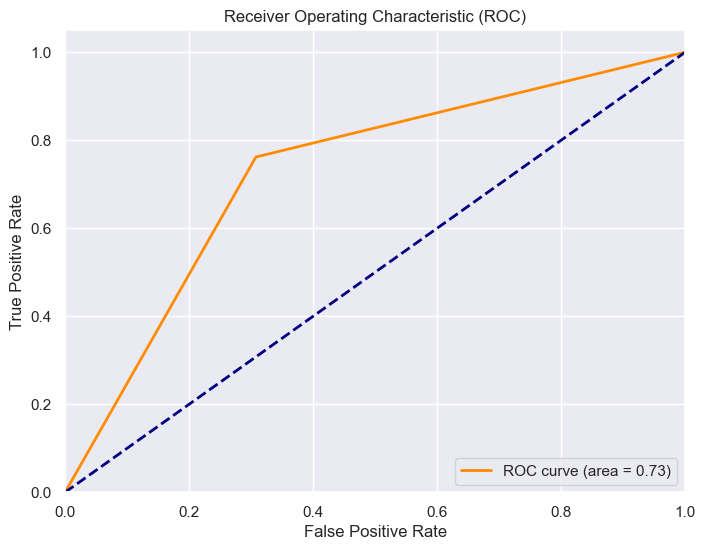

Model  F1-Score  AUC-Score   Assessment
0  HistGradientBoostingClassifier      0.65       0.73  Overfitting

In [68]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, HistGradientBoostingClassifier, random_state=42)
hgb_RE = result_df
hgb_RE

#### Balanced Model 7

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


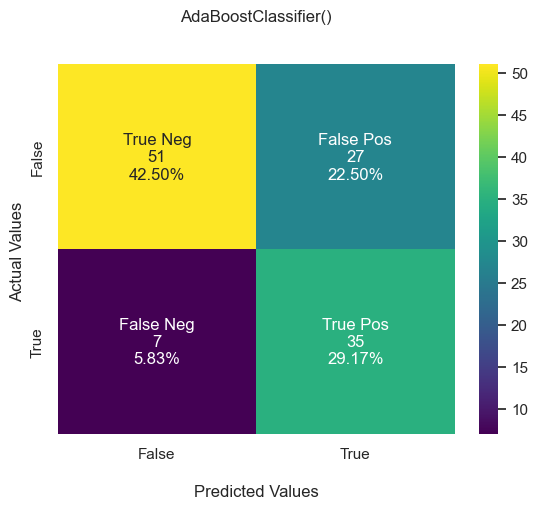

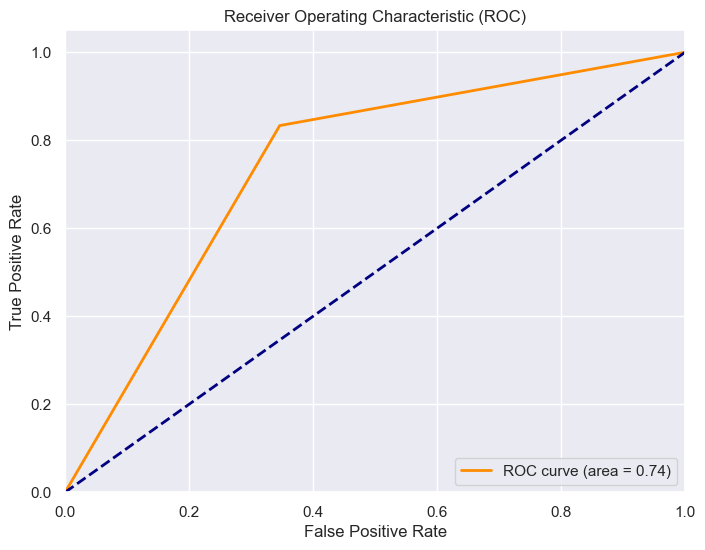

Model  F1-Score  AUC-Score   Assessment
0  AdaBoostClassifier      0.67       0.74  Overfitting

In [69]:
result_df = train_ml_model(X_train_resampled,y_train_resampled, X_eval_df, y_eval, AdaBoostClassifier, random_state=42)
adb_RE = result_df
adb_RE

### Models comparison For Balanced Dataset

In [70]:
balanced_results= {'model':['Decision Tree','Random Forest','AdaBoost','Logistic Regression','KNeighbors','HistGradientBoosting','SGBoost'],
         'f1_score':[dt_RE['F1-Score'].iloc[0],rf_RE['F1-Score'].iloc[0],lr_RE['F1-Score'].iloc[0],knn_RE['F1-Score'].iloc[0],hgb_RE['F1-Score'].iloc[0],
                    sgd_RE['F1-Score'].iloc[0], adb_RE['F1-Score'].iloc[0]],                  
         'AUC_score':[dt_RE['AUC-Score'].iloc[0],rf_RE['AUC-Score'].iloc[0],lr_RE['AUC-Score'].iloc[0],knn_RE['AUC-Score'].iloc[0],hgb_RE['AUC-Score'].iloc[0],
                    sgd['AUC-Score'].iloc[0], adb_RE['AUC-Score'].iloc[0]],
         'Assessment':[dt_RE['Assessment'].iloc[0],rf_RE['Assessment'].iloc[0],lr_RE['Assessment'].iloc[0],knn_RE['Assessment'].iloc[0],hgb_RE['Assessment'].iloc[0],
                    sgd_RE['Assessment'].iloc[0], adb_RE['Assessment'].iloc[0]]
}

balanced_results_df= pd.DataFrame(results)
balanced_results_df = results_df.sort_values(by ='AUC_score', ascending =False)
balanced_results_df

model  f1_score  AUC_score    Assessment
4            KNeighbors      0.66       0.74   Overfitting
5  HistGradientBoosting      0.63       0.72  Underfitting
2              AdaBoost      0.61       0.70   Overfitting
3   Logistic Regression      0.60       0.69   Overfitting
1         Random Forest      0.58       0.68   Overfitting
0         Decision Tree      0.58       0.67   Overfitting
6               SGBoost      0.56       0.67   Overfitting

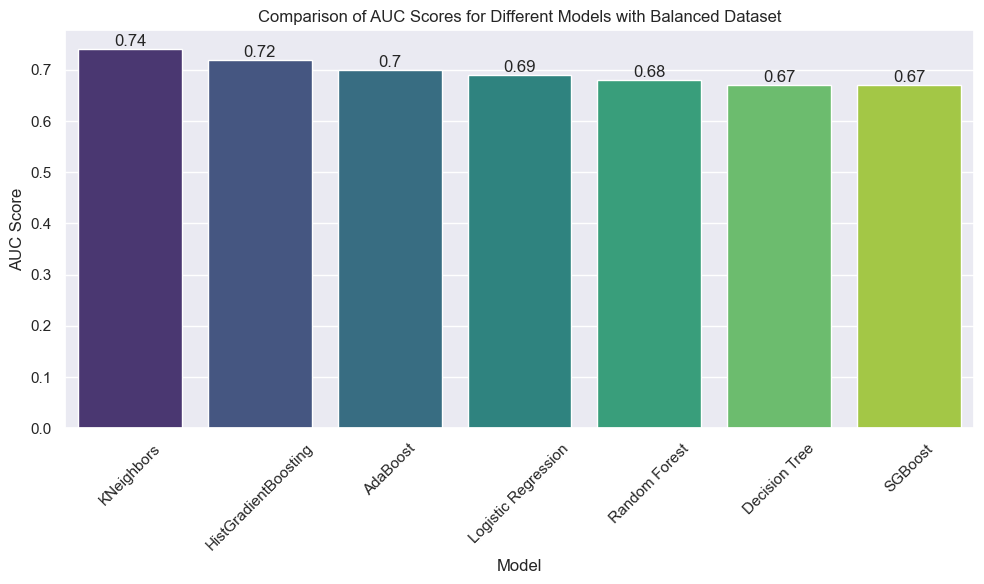

In [71]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=balanced_results_df, x='model', y='AUC_score', palette='viridis')

# Add data labels
for i, value in enumerate(balanced_results_df['AUC_score']):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')

# Set other plot properties
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models with Balanced Dataset')
plt.tight_layout()
plt.show()

In [72]:
results_df['Dataset'] = 'Unbalanced'
balanced_results_df['Dataset'] = 'Balanced'

combined_results = pd.concat([results_df, balanced_results_df], ignore_index=True)


In [73]:
combined_results.sort_values(by ='AUC_score', ascending =False)

model  f1_score  AUC_score    Assessment     Dataset
0             KNeighbors      0.66       0.74   Overfitting  Unbalanced
7             KNeighbors      0.66       0.74   Overfitting    Balanced
1   HistGradientBoosting      0.63       0.72  Underfitting  Unbalanced
8   HistGradientBoosting      0.63       0.72  Underfitting    Balanced
2               AdaBoost      0.61       0.70   Overfitting  Unbalanced
9               AdaBoost      0.61       0.70   Overfitting    Balanced
3    Logistic Regression      0.60       0.69   Overfitting  Unbalanced
10   Logistic Regression      0.60       0.69   Overfitting    Balanced
4          Random Forest      0.58       0.68   Overfitting  Unbalanced
11         Random Forest      0.58       0.68   Overfitting    Balanced
5          Decision Tree      0.58       0.67   Overfitting  Unbalanced
6                SGBoost      0.56       0.67   Overfitting  Unbalanced
12         Decision Tree      0.58       0.67   Overfitting    Balanced
13               SGBoost      0.56       0.67   Overfitting    Balanced

In [74]:
# Visualization with Plotly
fig = px.bar(combined_results, x='AUC_score', y='model', color='Dataset', title='AUC Score Comparison')
fig.update_layout(yaxis_title='Model')
fig.show()

fig = px.bar(combined_results, x='f1_score', y='model', color='Dataset', title='F1 Score Comparison')
fig.update_layout(yaxis_title='Model')
fig.show()

#fig = px.bar(combined_results, x='Assessment', y='model', color='Dataset', title='Assessment Comparison')
#fig.update_layout(yaxis_title='Model')
#fig.show()

### Grid Search and Feature Importance

In [75]:
# Function for Hyperparameter Tuning and Feature Importances

def feature_importance_and_tuning(model_name, X_train, y_train, X_test, y_test):
    # Hyperparameter Tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name} - Feature Importance")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    return best_model, f1, auc

In [76]:
#  X_train_resampled,y_train_resampled, X_eval_df, y_eval

In [77]:
#model_name = 'K-Nearest Neighbors'
#model = KNeighborsClassifier()
#param_grid = {
#'n_neighbors' : range(1, 21, 2),
#'weights' : ['uniform', 'distance'],
#'metric' : ['euclidean', 'manhattan', 'minkowski']
#}

#knn_imp = feature_importance_and_tuning(model_name, X_train_resampled,y_train_resampled, X_eval_df, y_eval )

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



   feature  importance_mean
1        1         0.141214
5        5         0.090735
7        7         0.037220
6        6         0.033546
3        3         0.024121
0        0         0.017093
4        4         0.016294
2        2         0.011502
8        8         0.000000


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best Score: 0.774059 using {'learning_rate': 0.1, 'n_estimators': 200}


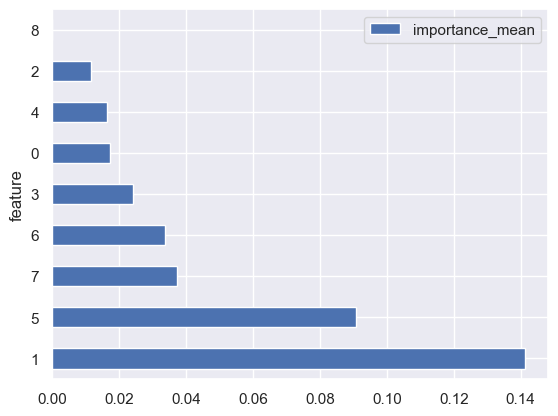

In [82]:


# Create AdaBoost model
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Perform permutation feature importance
perm_importance = permutation_importance(model, X_train_resampled, y_train_resampled, n_repeats=10, random_state=42)

# Create a DataFrame to store and visualize the results
X_train_resampled_df = pd.DataFrame(X_train_resampled)
importance_df = pd.DataFrame({'feature': X_train_resampled_df.columns, 'importance_mean': perm_importance.importances_mean})
importance_df = importance_df.sort_values('importance_mean', ascending=False)

# Print and visualize top features
print(importance_df.head(10))
importance_df.plot.barh(x='feature', y='importance_mean')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Create a repeated stratified K-fold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_resampled, y_train_resampled)

# Summarize results
print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



   feature  importance_mean
1        1         0.226518
5        5         0.130351
6        6         0.053195
7        7         0.040575
0        0         0.029393
2        2         0.027157
3        3         0.023003
8        8         0.014696
4        4         0.014217


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best Score: 0.817341 using {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 300}


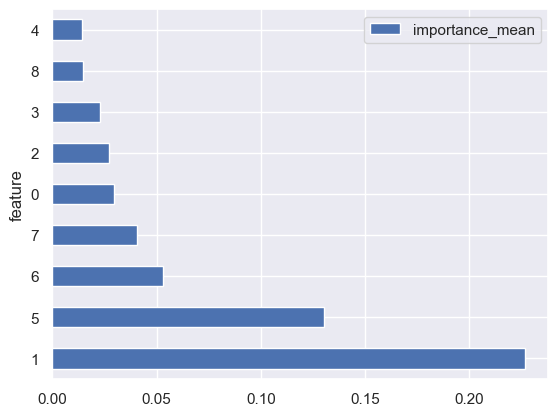

In [83]:
# Create Histogram Gradient Boosting model
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Perform permutation feature importance
perm_importance = permutation_importance(model, X_train_resampled, y_train_resampled, n_repeats=10, random_state=42)

# Create a DataFrame to store and visualize the results
X_train_resampled_df = pd.DataFrame(X_train_resampled)
importance_df = pd.DataFrame({'feature': X_train_resampled_df.columns, 'importance_mean': perm_importance.importances_mean})
importance_df = importance_df.sort_values('importance_mean', ascending=False)

# Print and visualize top features
print(importance_df.head(10))
importance_df.plot.barh(x='feature', y='importance_mean')

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

# Create a repeated stratified K-fold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_resampled, y_train_resampled)

# Summarize results
print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Feature: 0, Score: 0.04473
Feature: 1, Score: 0.10479
Feature: 2, Score: 0.02716
Feature: 3, Score: 0.05719
Feature: 4, Score: 0.00863
Feature: 5, Score: 0.03770
Feature: 6, Score: 0.03387
Feature: 7, Score: 0.04058
Feature: 8, Score: 0.06326


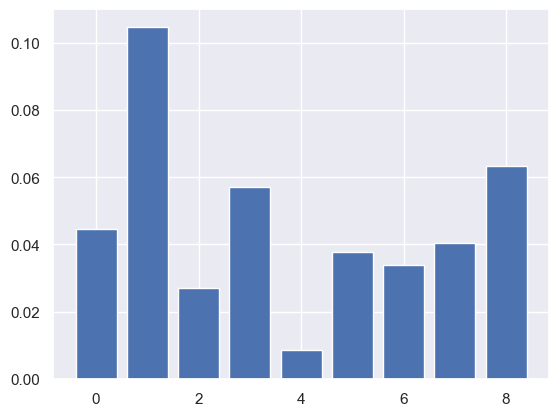

Best Score: 0.842422 using {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [87]:
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X_train_resampled, y_train_resampled)
# perform permutation importance
results = permutation_importance(model, X_train_resampled, y_train_resampled, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Define the parameter grid for GridSearchCV
param_grid = {
'n_neighbors' : range(1, 21, 2),
'weights' : ['uniform', 'distance'],
'metric' : ['euclidean', 'manhattan', 'minkowski']
}

# Create a repeated stratified K-fold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_resampled, y_train_resampled)

# Summarize results
print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [90]:

best_model = KNeighborsClassifier(metric='euclidean', n_neighbors=1, weights='uniform')


In [91]:
# set the destination path to the "export" directory
destination = "."

# create a dictionary to store the objects and their filenames
models = {"numerical_imputer": numerical_imputer,
          "label_encoder": label_encoder,
          "scaler": scaler,
          "Final_model": best_model}

# loop through the models and save them using joblib.dump()
for name, model in models.items():
    dump(model, os.path.join(destination, f"{name}.joblib"))